In [21]:
# 10082023, added the plot to get some visualization of the data
# Xinqiao Zhang

##  Last update on 09/21/2023 by Xinqiao Zhang
##  The following code takes random 2 trace files and evaluate the classification performance by using Xgboost. then it will plot all the ROC-AUC.



import numpy as np
import glob
import os
import glob
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn import svm
from sklearn.metrics import mean_squared_error, auc, RocCurveDisplay
import glob
import os
import pickle

In [22]:
def get_CWE_numbers(path):
    folder_names = []
    for name in os.listdir(path):
        if os.path.isdir(os.path.join(path, name)):
            folder_name = name.split('_')[0]
            folder_names.append(folder_name[3:])
    return folder_names

# npy_path = './LTP-data/'
distilled_folder = "/data/xinqiao/akira/distilled_data/"
npy_path = "/data/xinqiao/akira/distilled_data/"
all_files = glob.glob(npy_path+"*.pkl")

tem_file = all_files[1]
print(tem_file)

UAF_category = ['_operator','_malloc_free','_new_delete_array','_new_delete','_return']
UAF_subcategory = [['_equals'],['_char_','_int_','_int64_','_long_','_struct'],['_char_','_int_','_int64_','_long_','_struct_','_class'],['_char_','_int_','_int64_','_long_','_struct_','_class_','_wchart'],['`_freed_ptr']]
load_folder = "/data/xinqiao/akira/windowed_data_row/"
# filename_num = 587663

path_to_files = "/home/xinqiao/5-trojanai/akira-tcs/workloads/juliet/src/testcases/"
CWE_list = get_CWE_numbers(path_to_files)
# CWE_list = ['121']
CWE_list = ['416']

i = 1; j = 0
filename_cat = UAF_category[i]
filename_subcat = UAF_subcategory[i][j]
keywords = filename_cat + filename_subcat

# with open(save_folder + "CWE" +keywords+"iisig_data.pkl", "rb") as f: 
#         iisig_data = pickle.load(f)
# with open(save_folder + "CWE" +keywords+"iisig_labels.pkl", "rb") as f: 
#         iisig_labels = pickle.load(f)
batch_size = 1000
                
with open(distilled_folder + "CWE_0202_" +keywords+"_batch_"+str(batch_size)+"_iisig_interesting_data.pkl", "rb") as f:
    X_interesting = pickle.load(f)
with open(distilled_folder + "CWE_0202_" +keywords+"_batch_"+str(batch_size)+"_iisig_common_data.pkl", "rb") as f:
    X_common = pickle.load(f)
with open(distilled_folder + "CWE_0202_" +keywords+"_batch_"+str(batch_size)+"_iisig_interesting_labels.pkl", "rb") as f:
    y_interesting = pickle.load(f)   
with open(distilled_folder + "CWE_0202_" +keywords+"_batch_"+str(batch_size)+"_iisig_common_labels.pkl", "rb") as f:
    y_common = pickle.load(f) 
                
# with open(distilled_folder + "CWE" +keywords+"iisig_interesting_data.pkl", "wb") as fp:
#     pickle.dump(X_train, fp)
# with open(distilled_folder + "CWE" +keywords+"iisig_common_data.pkl", "wb") as fp:
#     pickle.dump(X_outlier, fp)
# with open(distilled_folder + "CWE" +keywords+"iisig_interesting_labels.pkl", "wb") as fp:
#     pickle.dump(interesting_label, fp)    
# with open(distilled_folder + "CWE" +keywords+"iisig_common_labels.pkl", "wb") as fp:
#     pickle.dump(common_label, fp) 

# tem_data = np.load(tem_file)
X_common_array = np.array(X_common)
X_interesting_array = np.array(X_interesting)
print("X_interesting.shape", X_interesting_array.shape)
print("X_common.shape", X_common_array.shape) # (xxx, 156)

# print("total number of interesting traces", len(y_interesting_adv[:cut_length]))
# print("total number of normal traces", len(y_common[:cut_length]))
print("True_positive", y_interesting.sum()/len(y_interesting))
print("False_positive: ", y_common.sum()/len(y_common))

# X_common_array = X_common_array[:5000,:]
# X_interesting_array = X_interesting_array[:5000,:]
# (2892, 156)


/data/xinqiao/akira/distilled_data/CWE_0202__malloc_free_char__batch_100_iisig_common_data.pkl
X_interesting.shape (346, 156)
X_common.shape (789, 156)
True_positive 0.4913294797687861
False_positive:  0.5183776932826363


In [12]:
# len(X_interesting_array[X_interesting_array==1])
# len(X_interesting_array)
# y_interesting
# print("True_positive", y_interesting.sum()/len(y_interesting))
print("False_positive: ", y_common.sum()/len(y_common))

False_positive:  0.5183776932826363


In [ ]:
#windowing transformation
from einops import rearrange
class WindowingLabelingTransform:
    """ 
    This class needs to return PyTorch Tensors
    """
    def __init__(self, window_width, label_threshold=0.6):
        self._w = window_width
        self._lthresh = label_threshold

    def get_labels(self, trace, bad=False):
        # target_pid = 62
        df = trace.data_frame
        lw = trace.labeled_windows
        cycles = df.index.to_numpy()
        # cycle_labels = np.zeros((len(cycles), num_labels))

        # For each labeled window, find it's start and end cycle -> set it's label vector
        for fw in lw:
            # Find the start,end indices of the window
            label = fw.label
            c_min = find_le(cycles, min(fw.range)) + 1
            c_max = find_le(cycles, max(fw.range))
            # label_idx = label_map[label]
            # cycle_labels[c_min:c_max, label_idx] = 1
        return cycle_labels
    
    def __call__(self, sample, fast=False):
        w = self._w                                                                                                                                        
        df = sample['df']
        trace = sample['trace']
        # Check if we should insert malicious labels
        bad = False
        if 'bad' in trace.id.lower():
            bad = True
        # Truncate shape to window boundaries
        dft = rearrange(df.to_numpy()[:-(df.shape[0] % w)], '(w time) c -> w time c', time=w)
        if fast:
            return {'df': dft, 'bad': bad}
        else:
            labels = self.get_labels(trace, bad=bad)
            cycles = df.index.to_numpy()
            labels_w = rearrange(labels[:-(labels.shape[0] % w)], '(w time) labels -> w time labels', time=w)
            cycles_w = rearrange(cycles[:-(cycles.shape[0] % w)], '(w time) -> w time', time=w)

            assert dft.shape[0] == labels_w.shape[0], "Label shape mismatch"

            # If enough of the labels in a window are bad then label that whole window
            # labels = np.zeros(labels_w.shape[0])
            threshs = np.sum(labels_w, axis=1) / labels_w.shape[1] # percent of bad windows
            # labels[threshs >= self._lthresh] = 1
            return {'df': dft, 'labels': threshs, 'bad': bad, 'cycles': cycles_w}

keywords _char_popen
converted_array [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 

ValueError: Please reshape the input data into 2-dimensional matrix.

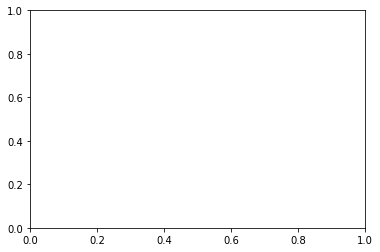

In [40]:
# ROC AUC for normal windows from two traces and both insteresting windows
tprs = []
aucs = []
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn import svm
from sklearn.metrics import mean_squared_error, auc, RocCurveDisplay
cv = KFold(n_splits=3, shuffle=True)
version = 3

UAF_category = ['_operator','_malloc_free','_new_delete_array','_new_delete','_return']
UAF_subcategory = [['_equals'],['_char_','_int_','_int64_','_long_','_struct'],['_char_','_int_','_int64_','_long_','_struct_','_class'],['_char_','_int_','_int64_','_long_','_struct_','_class_','_wchart'],['`_freed_ptr']]
load_folder = "/data/xinqiao/akira/windowed_data_row/"
# filename_num = 587663

path_to_files = "/home/xinqiao/5-trojanai/akira-tcs/workloads/juliet/src/testcases/"
CWE_list = get_CWE_numbers(path_to_files)
# CWE_list = ['121']
CWE_list = ['416']
distilled_folder = "/data/xinqiao/akira/distilled_data/"
save_folder = "/data/xinqiao/akira/windowed_iisig/"
load_folder = "/data/xinqiao/akira/distilled_data/pkl_rui/"
# for i in range(len(UAF_category)):
#     for j in range(len(UAF_subcategory[i])):
for tem_batch_size in [0]:
    i = 1; j= 0

    filename_cat = UAF_category[i]
    filename_subcat = UAF_subcategory[i][j]

    if not os.path.exists(distilled_folder):
        os.makedirs(distilled_folder)

    # keywords = filename_cat + filename_subcat
    keywords = '_char_popen'
    print("keywords", keywords)
    try:
        with open(load_folder + "CWE426_char_popen_data.pkl", "rb") as f: 
                raw_iisig_data = pickle.load(f)
        with open(load_folder + "CWE426_char_popen_labels.pkl", "rb") as f: 
                raw_iisig_labels = pickle.load(f)
        # with open(save_folder + "CWE426" +keywords+"iisig_data.pkl", "rb") as f: 
        #         raw_iisig_data = pickle.load(f)
        # with open(save_folder + "CWE426_" +keywords+"iisig_labels.pkl", "rb") as f: 
        #         raw_iisig_labels = pickle.load(f)
    except:
        print("keywords", keywords, "not found")
        continue


    raw_iisig_labels = np.array(raw_iisig_labels)
    array = np.array(raw_iisig_labels)
    non_zero_indices = np.nonzero(raw_iisig_labels)[0]
    assert len(non_zero_indices) == len(all_all_labels)
    converted_array = np.where(array > 0, 1, 0)
    print("converted_array", converted_array)
    all_all_data = raw_iisig_data
    all_all_labels = converted_array
    print("all_all_data", all_all_data.shape, "all_all_labels", all_all_labels.shape)
    # print("all_all_normal_label", all_all_normal_label.shape, "all_all_interesting_label", all_all_interesting_label.shape, all_all_normal.shape, all_all_interesting.shape)
    
    # X = all_all_normal
    # clean_y = np.copy(all_all_normal_label)
    # y = clean_y


    title_all = ['interesting','common','both']


    for exp_num in [2]: #0--> AB interesting, 1 --> AB normal, 2 --> AB all 
        if exp_num == 0:
            X = all_all_interesting
            clean_y = np.copy(all_all_interesting_label)
        elif exp_num == 1:
            X = all_all_normal
            clean_y = np.copy(all_all_normal_label)
        elif exp_num ==2:
            X = all_all_data
            clean_y = np.copy(all_all_labels)
        y = clean_y
        xg_reg = xgb.XGBClassifier(objective ='binary:logistic', subsample=0.9,
                        max_depth = 50,n_estimators = 10, use_label_encoder=False)
        # X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)
        # kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
        mean_fpr = np.linspace(0, 1, 100)
        # title = "ROC Xgboost for 2 traces (label 0: trace A "+title_all[exp_num]+" windows Num=" +str(len(clean_y[clean_y==0])) + ") \n (label 1: trace B "+title_all[exp_num]+" windows Num= "+str(len(clean_y[clean_y==1]))+")" 
        # title ='ROC Xgboost_'+file_name1.split("_")[7] + '_' +str(len(clean_y[clean_y==0]))+'_'+ file_name2.split("_")[7]+'_'+str(len(clean_y[clean_y==1]))+'_'+str(title_all[exp_num])
        title ='ROC Xgboost_'+str(len(clean_y[clean_y==0]))+'_'+str(len(clean_y[clean_y==1]))+'_'+str(title_all[exp_num])
        fig, ax = plt.subplots()
        for i, (train, test) in enumerate(cv.split(X,y)):
            xg_reg.fit(X[train], y[train])
            viz = RocCurveDisplay.from_estimator(
                xg_reg,
                X[test],
                y[test],
                name="ROC fold {}".format(i),
                alpha=0.3,
                lw=1,
                ax=ax,
            )
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title=title,
        )
        ax.legend(loc="lower right")
        # plt.show()
        # fig.savefig(save_path + 'Xgb_ROC_normal_AB_traces_v2.png')
        # if mean_auc > 0.60:
        epoch = 0
        save_path ="./"
        fig.savefig(save_path + 'Xgb_ROC_'+title_all[exp_num]+'_AB_traces_'+str(epoch)+'_v2_shuffle.png')
        


In [43]:
# array = np.array(raw_iisig_labels)
# sumarray
sum(converted_array)/len(converted_array)
# non_zero_indices = np.nonzero(array)[0]
# assert len(non_zero_indices) == len(all_all_labels)
# converted_array = np.where(array > 0, 1, 0)


# ceiling_array = np.floor(array)
# print("array", array)
# print("ceiling_array", ceiling_array)
# non_zero_indices



0.11385199240986717

In [63]:
# test all the distlled data in a folder

def get_CWE_numbers(path):
    folder_names = []
    for name in os.listdir(path):
        if os.path.isdir(os.path.join(path, name)):
            folder_name = name.split('_')[0]
            folder_names.append(folder_name[3:])
    return folder_names

# npy_path = './LTP-data/'
distilled_folder = "/data/xinqiao/akira/distilled_data/"
npy_path = "/data/xinqiao/akira/distilled_data/"
all_files = glob.glob(npy_path+"*.pkl")

tem_file = all_files[1]
print(tem_file)

UAF_category = ['_operator','_malloc_free','_new_delete_array','_new_delete','_return']
UAF_subcategory = [['_equals'],['_char_','_int_','_int64_','_long_','_struct'],['_char_','_int_','_int64_','_long_','_struct_','_class'],['_char_','_int_','_int64_','_long_','_struct_','_class_','_wchart'],['`_freed_ptr']]
load_folder = "/data/xinqiao/akira/windowed_data_row/"
# filename_num = 587663

path_to_files = "/home/xinqiao/5-trojanai/akira-tcs/workloads/juliet/src/testcases/"
CWE_list = get_CWE_numbers(path_to_files)
# CWE_list = ['121']
CWE_list = ['416']

# i = 1; j = 0
for i in range(len(UAF_category)):
    for j in range(len(UAF_subcategory[i])):
        filename_cat = UAF_category[i]
        filename_subcat = UAF_subcategory[i][j]
        keywords = filename_cat + filename_subcat

        batch_size = 500
        try:                
            with open(distilled_folder + "CWE" +keywords+"_batch_"+str(batch_size)+"_iisig_interesting_data.pkl", "rb") as f:
                X_interesting = pickle.load(f)
            with open(distilled_folder + "CWE" +keywords+"_batch_"+str(batch_size)+"_iisig_common_data.pkl", "rb") as f:
                X_common = pickle.load(f)
            with open(distilled_folder + "CWE" +keywords+"_batch_"+str(batch_size)+"_iisig_interesting_labels.pkl", "rb") as f:
                y_interesting = pickle.load(f)   
            with open(distilled_folder + "CWE" +keywords+"_batch_"+str(batch_size)+"_iisig_common_labels.pkl", "rb") as f:
                y_common = pickle.load(f) 
        except:
            continue
        
        
                        
        X_common_array = np.array(X_common)
        X_interesting_array = np.array(X_interesting)
        
        # True_positive_rate = sum(y_interesting==1)/(sum(y_interesting==1) + sum(y_common==1))
        # False_positive_rate = sum(y_common==1)/(sum(y_interesting==1) + sum(y_common==1))
        # True_positive_rate =  sum(y_interesting==1)/sum(y_interesting==1)
        True_positive_rate = 0
        False_positive_rate = sum(y_common==1)/len(y_common)
        print("filename is: ", keywords+str(batch_size), "True_positive_rate is", True_positive_rate, "False_positive_rate is", False_positive_rate)
        print("True_positive", sum(y_interesting==1), sum(y_common==1) , sum(y_interesting==1) + sum(y_common==1))
        # print("False_positive", sum(y_common==1),'/', len(y_common))
        # print("X_interesting.shape", X_interesting_array.shape)
        # print("X_common.shape", X_common_array.shape) # (xxx, 156)

        # print("True_positive_total number of interesting trace with label == 1: ", len(X_interesting_array[X_interesting_array==1]))
        # print("False_positive_total number of normal trace with label == 1: ", len(y_common[y_common==1]))

# X_common_array = X_common_array[:5000,:]
# X_interesting_array = X_interesting_array[:5000,:]
# (2892, 156)


/data/xinqiao/akira/distilled_data/CWE_new_delete_array_int64__batch_1000_iisig_common_data.pkl
filename is:  _malloc_free_int64_1000 True_positive_rate is 0 False_positive_rate is 0.0017550863753223284
True_positive 6 910 916
filename is:  _malloc_free_long_1000 True_positive_rate is 0 False_positive_rate is 0.0018181093257844583
True_positive 4 912 916
filename is:  _new_delete_array_char_1000 True_positive_rate is 0 False_positive_rate is 0.0010825020052135552
True_positive 1 691 692
filename is:  _new_delete_array_int_1000 True_positive_rate is 0 False_positive_rate is 0.0014437801477862828
True_positive 2 915 917
filename is:  _new_delete_array_int64_1000 True_positive_rate is 0 False_positive_rate is 0.0014454660758284545
True_positive 2 914 916
filename is:  _new_delete_array_long_1000 True_positive_rate is 0 False_positive_rate is 0.001434121706715027
True_positive 9 911 920
filename is:  _new_delete_array_struct_1000 True_positive_rate is 0 False_positive_rate is 0.00144324818

In [28]:
kk  =np.array(y_common).reshape(-1)
np.unique(kk.all())


array([False])

In [4]:
# len(X_common)
# X_common[0].shape
# X_interesting_array[0].shape
# len(y_interesting)
# len(y_common)
# X_common_array.shape
# y_common.shape

all_both_data shape is (1135, 156)
total number of interesting traces 346
total number of normal traces 789
True_positive_total number of interesting trace with label == 3:  170
False_positive_total number of normal trace with label == 3:  409


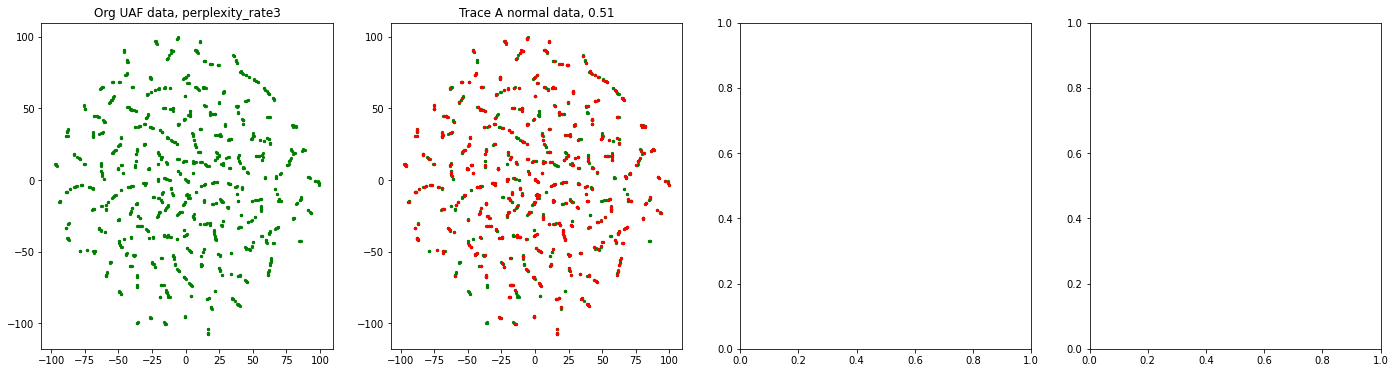

In [20]:
# Print the label for different traces (MAIN script)
# version  =2 
# datafolder_path = './processed_LTP_v' + str(version) + '/' 
# processed_files = glob.glob(datafolder_path+"processed_batch1_*.npy")
# # labels 1--> trace A normal, 2--> trace B normal, 3--> insteresting tarces
# # for perplexity_rate in [3,10,15,20,25,30,35]:
import datetime
current_timestamp = datetime.datetime.now()
perplexity_rate  = 3
if 1: 
    # cut_length = len(y_interesting)
    # cut_length = -1
    both_data = np.concatenate((X_interesting_array, X_common_array), axis=0)
    # all_both_data = np.concatenate(both_data, axis=0)   
    all_both_data = both_data
    # both_labels
    y_interesting_adv = y_interesting
    both_labels = np.concatenate((y_interesting_adv, y_common), axis=0)
    # all_both_labels = np.concatenate(both_labels, axis=0)
    all_both_labels = both_labels
    print("all_both_data shape is", all_both_data.shape)
    
    X_embedded_all = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=perplexity_rate).fit_transform(all_both_data)
    # X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)

    fig, axis = plt.subplots(1,4, figsize=(24, 6))

    
    axis[0].scatter(X_embedded_all[:,0], X_embedded_all[:,1], marker='o', color='green', s=5)
    # axis[0].scatter(X_embedded_all[cut_length:,0], X_embedded_all[cut_length:,1], marker='o', color='blue', s=5)
    # axis[0].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)

    axis[1].scatter(X_embedded_all[:,0], X_embedded_all[:,1], marker='o', color='green', s=5)
    axis[1].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)

    # axis[2].scatter(X_embedded_all[:,0], X_embedded_all[:,1], marker='o', color='blue', s=5)
    # axis[2].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)
    
    # axis[3].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)
    # axis[3].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='blue', s=5)
  
    axis[0].title.set_text("Org UAF data, perplexity_rate" + str(perplexity_rate))
    axis[1].title.set_text("Trace A normal data, {:.2f}".format(len(X_embedded_all[all_both_labels==1,0])/len(X_embedded_all)))
    # axis[2].title.set_text("Trace B normal data, {:.2f}".format(len(X_embedded_all[all_both_labels==0,0])/len(X_embedded_all)))
    # axis[3].title.set_text("interesting LTP data, {:.2f}".format(len(X_embedded_all[all_both_labels==0,0])/len(X_embedded_all)))
    save_path = 'tsne_akira/'
    fig.savefig(save_path + '_'+str(current_timestamp)+'_'+keywords+'_'+str(perplexity_rate)+ '.png')
    # calculate the false rate:
    print("total number of interesting traces", len(y_interesting_adv[:]))
    print("total number of normal traces", len(y_common[:]))
    print("True_positive_total number of interesting trace with label == 3: ", len(y_interesting_adv[:][y_interesting_adv[:]==1]))
    print("False_positive_total number of normal trace with label == 3: ", len(y_common[:][y_common[:]==1]))
    # fig.savefig(save_path + 'TSNE0630_2_traces_'+file_name1.split("_")[3] + '_' + file_name2.split("_")[3] + '_perplextity_'+str(perplexity_rate)+ 'batchsize'+file_name2.split("_")[1]+'.png')

In [18]:
# both_labels.shape
X_embedded_all.shape

(1135, 2)

all_both_data shape is (1135, 156)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1135 but corresponding boolean dimension is 1133

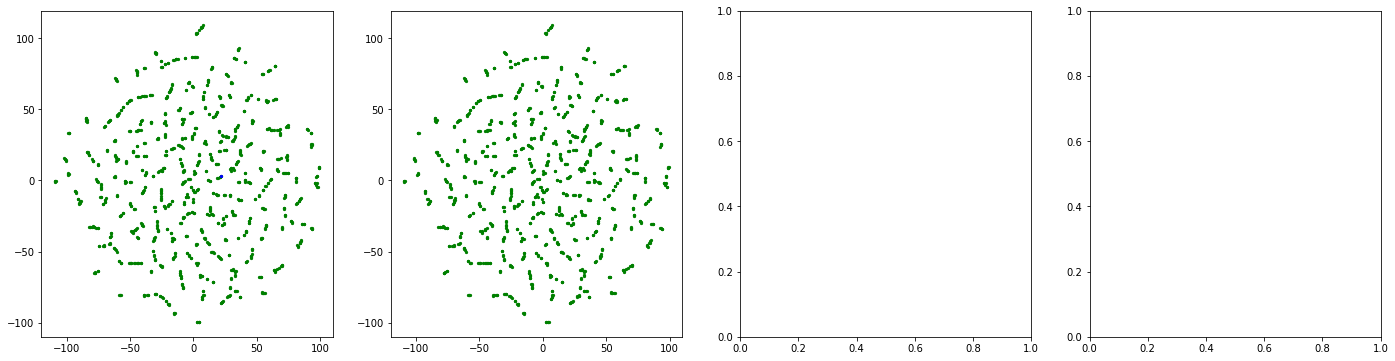

In [14]:
# Print the label for different traces (MAIN script)
# version  =2 
# datafolder_path = './processed_LTP_v' + str(version) + '/' 
# processed_files = glob.glob(datafolder_path+"processed_batch1_*.npy")
# # labels 1--> trace A normal, 2--> trace B normal, 3--> insteresting tarces
# # for perplexity_rate in [3,10,15,20,25,30,35]:
import datetime
current_timestamp = datetime.datetime.now()
perplexity_rate  = 3
if 1: 
    # cut_length = len(y_interesting)
    cut_length = -1
    both_data = np.concatenate((X_interesting_array, X_common_array), axis=0)
    # all_both_data = np.concatenate(both_data, axis=0)   
    all_both_data = both_data
    # both_labels
    y_interesting_adv = y_interesting
    both_labels = np.concatenate((y_interesting_adv[:cut_length], y_common[:cut_length]), axis=0)
    # all_both_labels = np.concatenate(both_labels, axis=0)
    all_both_labels = both_labels
    print("all_both_data shape is", all_both_data.shape)
    
    X_embedded_all = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=perplexity_rate).fit_transform(all_both_data)
    # X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)

    fig, axis = plt.subplots(1,4, figsize=(24, 6))

    
    axis[0].scatter(X_embedded_all[:cut_length,0], X_embedded_all[:cut_length,1], marker='o', color='green', s=5)
    axis[0].scatter(X_embedded_all[cut_length:,0], X_embedded_all[cut_length:,1], marker='o', color='blue', s=5)
    # axis[0].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)

    axis[1].scatter(X_embedded_all[:cut_length,0], X_embedded_all[:cut_length,1], marker='o', color='green', s=5)
    axis[1].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)

    axis[2].scatter(X_embedded_all[cut_length:,0], X_embedded_all[cut_length:,1], marker='o', color='blue', s=5)
    axis[2].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)
    
    axis[3].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='red', s=5)
    axis[3].scatter(X_embedded_all[all_both_labels==1,0], X_embedded_all[all_both_labels==1,1], marker='o', color='blue', s=5)
  
    axis[0].title.set_text("Org UAF data, perplexity_rate" + str(perplexity_rate))
    axis[1].title.set_text("Trace A normal data, {:.2f}".format(len(X_embedded_all[all_both_labels==1,0])/len(X_embedded_all)))
    axis[2].title.set_text("Trace B normal data, {:.2f}".format(len(X_embedded_all[all_both_labels==0,0])/len(X_embedded_all)))
    axis[3].title.set_text("interesting LTP data, {:.2f}".format(len(X_embedded_all[all_both_labels==0,0])/len(X_embedded_all)))
    save_path = 'tsne_akira/'
    fig.savefig(save_path + '_'+str(current_timestamp)+'_'+keywords+'_'+str(perplexity_rate)+ '.png')
    # calculate the false rate:
    print("total number of interesting traces", len(y_interesting_adv[:cut_length]))
    print("total number of normal traces", len(y_common[:cut_length]))
    print("True_positive_total number of interesting trace with label == 3: ", len(y_interesting_adv[:cut_length][y_interesting_adv[:cut_length]==1]))
    print("False_positive_total number of normal trace with label == 3: ", len(y_common[:cut_length][y_common[:cut_length]==1]))
    # fig.savefig(save_path + 'TSNE0630_2_traces_'+file_name1.split("_")[3] + '_' + file_name2.split("_")[3] + '_perplextity_'+str(perplexity_rate)+ 'batchsize'+file_name2.split("_")[1]+'.png')

In [50]:
# np.unique(all_both_labels==1)
# np.unique(all_both_labels==3)
print("total number of interesting traces", len(y_interesting_adv[:cut_length]))
print("total number of normal traces", len(y_common[:cut_length]))
print("True_positive_total number of interesting trace with label == 1: ", len(y_interesting_adv[:cut_length][y_interesting_adv[:cut_length]==1]))
print("False_positive_total number of normal trace with label == 1: ", len(y_common[:cut_length][y_common[:cut_length]==1]))

total number of interesting traces 169922
total number of normal traces 169922
True_positive_total number of interesting trace with label == 1:  13
False_positive_total number of normal trace with label == 1:  292


In [40]:
y_interesting_adv[:cut_length][y_interesting_adv[:cut_length]==1]

array([], dtype=float64)

In [32]:
all_both_labels
from collections import Counter
# zip(all_both_labels)
# Counter(all_both_labels)
both_labels = np.concatenate((y_common[:5000], y_interesting[:5000]), axis=0)
# Counter(both_labels)
# Counter(list(y_common))
y_common
# X_embedded_all.shape
# all_both_labels == 2

array([0.0, 0.0, 0.0, ..., array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [ ]:
# both_labels.shape
# all_both_data.shape
# both_data.shape
X_embedded_all = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=perplexity_rate).fit_transform(all_both_data)

(566955, 156)

file name is  processed_batch1_50_buffer_size_400_LTP_fchmod03_06-07-2023_195614_sig.npy_shuffle_1.npy
all_data shape is 1
file name is  processed_batch1_50_buffer_size_400_LTP_fcntl02_64_06-07-2023_200933_sig.npy_shuffle_1.npy
all_data shape is 2
file name is  processed_batch1_50_buffer_size_400_LTP_sbrk01_06-08-2023_030556_sig.npy_shuffle_1.npy
all_data shape is 3
file name is  processed_batch1_50_buffer_size_400_LTP_pread01_06-08-2023_015049_sig.npy_shuffle_1.npy
all_data shape is 4
file name is  processed_batch1_50_buffer_size_400_LTP_ptem01_06-08-2023_171806_sig.npy_shuffle_1.npy
all_data shape is 5
file name is  processed_batch1_50_buffer_size_400_LTP_lchown02_06-07-2023_231355_sig.npy_shuffle_1.npy
all_data shape is 6
file name is  processed_batch1_50_buffer_size_400_LTP_clock_nanosleep04_06-07-2023_182754_sig.npy_shuffle_1.npy
all_data shape is 7
file name is  processed_batch1_50_buffer_size_400_LTP_fs_perms_06-08-2023_085200_sig.npy_shuffle_1.npy
all_data shape is 8
file name 

/var/folders/pg/21p768nj7ql8xc_qftsb78n00000gn/T/ipykernel_18342/3726144906.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tem_data_interesting != []:


file name is  processed_batch1_50_buffer_size_400_LTP_fchmod03_06-07-2023_195614_sig.npy_shuffle_1.npy
all_data shape is 1
file name is  processed_batch1_50_buffer_size_400_LTP_fcntl02_64_06-07-2023_200933_sig.npy_shuffle_1.npy
all_data shape is 2
file name is  processed_batch1_50_buffer_size_400_LTP_sbrk01_06-08-2023_030556_sig.npy_shuffle_1.npy
all_data shape is 3
file name is  processed_batch1_50_buffer_size_400_LTP_pread01_06-08-2023_015049_sig.npy_shuffle_1.npy
all_data shape is 4
file name is  processed_batch1_50_buffer_size_400_LTP_ptem01_06-08-2023_171806_sig.npy_shuffle_1.npy
all_data shape is 5
file name is  processed_batch1_50_buffer_size_400_LTP_lchown02_06-07-2023_231355_sig.npy_shuffle_1.npy
all_data shape is 6
file name is  processed_batch1_50_buffer_size_400_LTP_clock_nanosleep04_06-07-2023_182754_sig.npy_shuffle_1.npy
all_data shape is 7
file name is  processed_batch1_50_buffer_size_400_LTP_fs_perms_06-08-2023_085200_sig.npy_shuffle_1.npy
all_data shape is 8
file name 

/var/folders/pg/21p768nj7ql8xc_qftsb78n00000gn/T/ipykernel_18342/3726144906.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tem_data_interesting != []:


KeyboardInterrupt: 

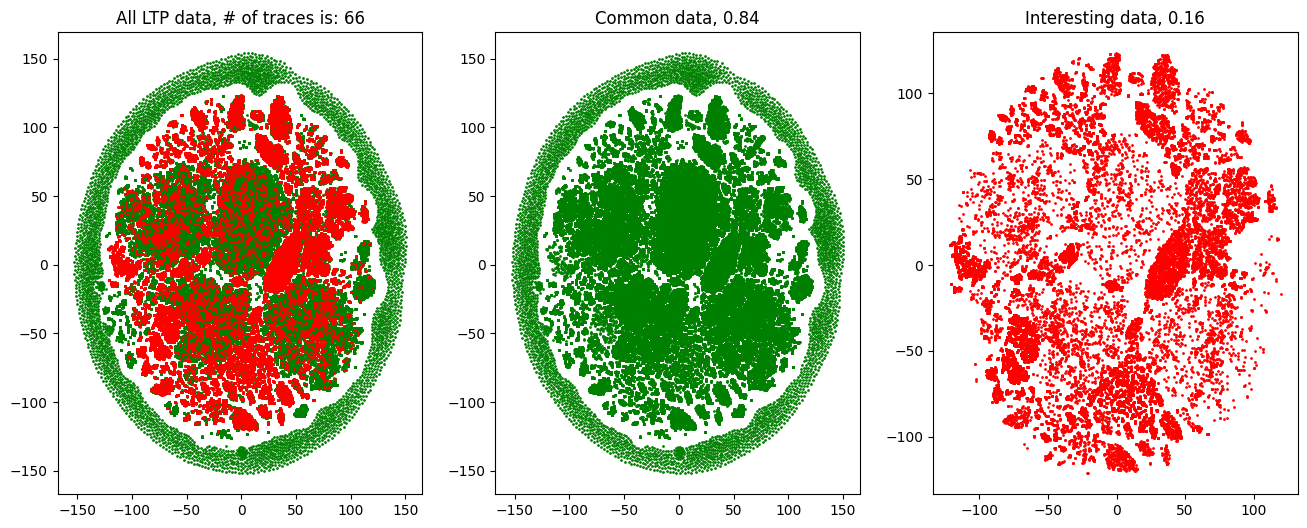

In [3]:
# Print the label for different traces (all files)
version = 2
datafolder_path = './processed_LTP_v' + str(version) + '/' 
processed_files = glob.glob(datafolder_path+"processed_batch1_50_*.npy")

# labels 1--> trace A normal, 2--> trace B normal, 3--> insteresting tarces
# for perplexity_rate in [3,10,15,20,25,30,35]:
# select_files = processed_files[:2]
# if 1:
for perplexity_rate  in [15,25,35]:
    # for file_number in range(5,20,5):
    for file_number in [100,200,275]:
        select_files = processed_files[:file_number]
        all_data =[]
        all_labels =[]
        # counter = 0
        for processed_file in select_files:
            file_name = os.path.basename(processed_file)
            interesting_filename = 'interesting_' + file_name
            interesting_files_path = datafolder_path + interesting_filename

            tem_data_interesting = np.load(interesting_files_path)
            file_name = os.path.basename(processed_file)
            print("file name is ", file_name)
            tem_data_processed = np.load(processed_file)
            if tem_data_interesting != []:
                all_data.append(np.concatenate((tem_data_interesting, tem_data_processed), axis=0))
            else:
                all_data.append(tem_data_processed)
            print("all_data shape is", len(all_data))
            
            all_labels.append(np.concatenate((np.ones(len(tem_data_interesting))*1, np.ones(len(tem_data_processed))*0),axis=0))
            if len(all_data) >= 15:
                break
        all_all_data = np.concatenate(all_data, axis=0)   
        all_all_labels = np.concatenate(all_labels, axis=0)
        # print("all_both_data shape is", all_both_data.shape)
        
        X_embedded_all = TSNE(n_components=2, learning_rate='auto',
                        init='random', perplexity=perplexity_rate).fit_transform(all_all_data)
        # X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)

        fig, axis = plt.subplots(1,3, figsize=(16, 6))


        axis[0].scatter(X_embedded_all[all_all_labels==0,0], X_embedded_all[all_all_labels==0,1], marker='o', color='green', s=1)
        # axis[0].scatter(X_embedded_all[all_all_labels==2,0], X_embedded_all[all_all_labels==2,1], marker='o', color='blue', s=5)
        axis[0].scatter(X_embedded_all[all_all_labels==1,0], X_embedded_all[all_all_labels==1,1], marker='o', color='red', s=1)

        axis[1].scatter(X_embedded_all[all_all_labels==0,0], X_embedded_all[all_all_labels==0,1], marker='o', color='green', s=1)
        # axis[2].scatter(X_embedded_all[all_all_labels==2,0], X_embedded_all[all_all_labels==2,1], marker='o', color='blue', s=5)

        axis[2].scatter(X_embedded_all[all_all_labels==1,0], X_embedded_all[all_all_labels==1,1], marker='o', color='red', s=1)

        normal_per = len(X_embedded_all[all_all_labels==0,0])/len(X_embedded_all)
        interesting_per = 1- normal_per
        axis[0].title.set_text("All LTP data, # of traces is: "+ str(len(select_files)))
        axis[1].title.set_text("Common data, {:.2f}".format(len(X_embedded_all[all_all_labels==0,0])/len(X_embedded_all)))
        axis[2].title.set_text("Interesting data, {:.2f}".format(len(X_embedded_all[all_all_labels==1,0])/len(X_embedded_all)))
        # axis[3].title.set_stext("interesting LTP data, {:.2f}".format(len(X_embedded_all[all_all_labels==3,0])/len(X_embedded_all)))
        save_path = 'tsne_akira/'
        fig.savefig(save_path + 'TSNE_v2_new_'+str(len(select_files))+'_traces_perplextity_'+str(perplexity_rate)+ '_batchsize_'+file_name.split("_")[2]+'.png')

In [7]:
# fig.savefig(save_path + 'TSNE_'+str(len(processed_files))+'_traces_perplextity_'+str(perplexity_rate)+ '_batchsize_'+file_name.split("_")[1]+'.png')
# str(len(processed_files))
tem_data_interesting.shape
# tem_data_interesting = np.load(interesting_files_path)
interesting_files_path

'./processed_LTP_v2/interesting_processed_batch1_50_buffer_size_400_LTP_export_06-08-2023_075556_sig.npy'

In [90]:
# ROC AUC for normal windows from two traces and both insteresting windows
tprs = []
aucs = []
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn import svm
from sklearn.metrics import mean_squared_error, auc, RocCurveDisplay
cv = KFold(n_splits=3, shuffle=True)

version = 3
datafolder_path = './processed_LTP_v' + str(version) + '/' 
processed_files = glob.glob(datafolder_path+"common_*.npy")

# labels 1--> trace A normal, 2--> trace B normal, 3--> insteresting tarces
# for perplexity_rate in [3,10,15,20,25,30,35]:
# select_files = processed_files[:2]
# if 1:

# for file_number in range(5,20,5):
# for file_number in [2]:
    # file_number = 2
for epoch in range(20):
    random_numbers = np.random.randint(low=0, high=len(processed_files), size=2)
    select_files = [processed_files[i] for i in random_numbers]
    # sublist = [my_list[i] for i in indices]
    all_data =[]
    all_labels =[]
    all_interesting = []
    all_interesting_label = []
    all_normal = []
    all_normal_label = []
    counter = 0
    for processed_file in select_files:
        
        file_name = os.path.basename(processed_file)
        
        interesting_filename = 'interesting_' + file_name[7:]
        interesting_files_path = datafolder_path + interesting_filename

        tem_data_interesting = np.load(interesting_files_path)
        file_name = os.path.basename(processed_file)
        print("file name is ", file_name)
        if counter ==0:
            file_name1 = file_name
        else:
            file_name2 = file_name
        tem_data_processed = np.load(processed_file)
        
        all_normal.append(tem_data_processed)
        all_normal_label.append(np.ones(len(tem_data_processed))*counter)
   
        all_interesting.append(tem_data_interesting)
        all_interesting_label.append(np.ones(len(tem_data_interesting))*counter)
        
        # all_data.append(np.concatenate((tem_data_interesting, tem_data_processed), axis=0))
        # else:
        #     all_data.append(tem_data_processed)
        counter +=1
        # print("all_data shape is", len(all_data))
        # all_labels.append(np.concatenate((np.ones(len(tem_data_interesting))*1, np.ones(len(tem_data_processed))*0),axis=0))
        
    # all_all_data = np.concatenate(all_data, axis=0)   
    # all_all_labels = np.concatenate(all_labels, axis=0)
    all_all_interesting  = np.concatenate(all_interesting, axis=0)
    all_all_interesting_label = np.concatenate(all_interesting_label, axis=0)
    all_all_normal  = np.concatenate(all_normal, axis=0)
    all_all_normal_label = np.concatenate(all_normal_label, axis=0)
    # assert len(all_all_labels) == len(all_all_normal_label) + len(all_all_interesting_label)
    print(len(all_all_normal_label))
    print(len(all_all_interesting_label))
    
    # X = all_all_normal
    # clean_y = np.copy(all_all_normal_label)
    # y = clean_y


    title_all = ['interesting','common','both']


    for exp_num in [0,1]: #0--> AB interesting, 1 --> AB normal, 2 --> AB all 
        if exp_num == 0:
            X = all_all_interesting
            clean_y = np.copy(all_all_interesting_label)
        elif exp_num == 1:
            X = all_all_normal
            clean_y = np.copy(all_all_normal_label)
        elif exp_num ==2:
            X = all_all_data
            clean_y = np.copy(all_all_labels)
        y = clean_y
        xg_reg = xgb.XGBClassifier(objective ='binary:logistic', subsample=0.9,
                        max_depth = 50,n_estimators = 10, use_label_encoder=False)
        # X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)
        # kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
        mean_fpr = np.linspace(0, 1, 100)
        # title = "ROC Xgboost for 2 traces (label 0: trace A "+title_all[exp_num]+" windows Num=" +str(len(clean_y[clean_y==0])) + ") \n (label 1: trace B "+title_all[exp_num]+" windows Num= "+str(len(clean_y[clean_y==1]))+")" 
        title ='ROC Xgboost_'+file_name1.split("_")[7] + '_' +str(len(clean_y[clean_y==0]))+'_'+ file_name2.split("_")[7]+'_'+str(len(clean_y[clean_y==1]))+'_'+str(title_all[exp_num])
        fig, ax = plt.subplots()
        for i, (train, test) in enumerate(cv.split(X,y)):
            xg_reg.fit(X[train], y[train])
            viz = RocCurveDisplay.from_estimator(
                xg_reg,
                X[test],
                y[test],
                name="ROC fold {}".format(i),
                alpha=0.3,
                lw=1,
                ax=ax,
            )
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title=title,
        )
        ax.legend(loc="lower right")
        # plt.show()
        # fig.savefig(save_path + 'Xgb_ROC_normal_AB_traces_v2.png')
        # if mean_auc > 0.60:
        fig.savefig(save_path + 'Xgb_ROC_'+title_all[exp_num]+'_AB_traces_'+str(epoch)+'_v2_shuffle.png')
        


ValueError: high <= 0

file name is  interesting_levenshtein_distance_LTP_shmctl02_06-08-2023_045825_sig.npy
file name is  interesting_levenshtein_distance_LTP_fcntl20_06-07-2023_203654_sig.npy
457


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_link05_06-07-2023_232005_sig.npy
file name is  interesting_levenshtein_distance_LTP_epoll_wait02_06-07-2023_191411_sig.npy
1463


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_splice04_06-08-2023_053947_sig.npy
file name is  interesting_levenshtein_distance_LTP_syscall01_06-08-2023_060701_sig.npy
553


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_epoll_ctl01_06-07-2023_190905_sig.npy
file name is  interesting_levenshtein_distance_LTP_fork06_06-07-2023_211921_sig.npy
923


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_sigaction02_06-08-2023_051352_sig.npy
file name is  interesting_levenshtein_distance_LTP_epoll_ctl05_06-07-2023_191127_sig.npy
276


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_pipeio__3_06-09-2023_162237_sig.npy
file name is  interesting_levenshtein_distance_LTP_inotify10_06-07-2023_225355_sig.npy
1265


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_fcntl31_64_06-07-2023_205323_sig.npy
file name is  interesting_levenshtein_distance_LTP_setreuid04_06-08-2023_043857_sig.npy
252


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_sendmmsg01_06-08-2023_035840_sig.npy
file name is  interesting_levenshtein_distance_LTP_pwrite04_06-08-2023_021450_sig.npy
680


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_readv01_06-08-2023_023638_sig.npy
file name is  interesting_levenshtein_distance_LTP_preadv202_06-08-2023_015937_sig.npy
870


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_pipeio_06-09-2023_161945_sig.npy
file name is  interesting_levenshtein_distance_LTP_lseek07_06-07-2023_232959_sig.npy
2544


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_sched_yield01_06-08-2023_032044_sig.npy
file name is  interesting_levenshtein_distance_LTP_getresgid02_06-07-2023_221631_sig.npy
270


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_msgctl01_06-08-2023_002920_sig.npy
file name is  interesting_levenshtein_distance_LTP_timerfd_settime01_06-08-2023_062211_sig.npy
339


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_preadv202_06-08-2023_015937_sig.npy
file name is  interesting_levenshtein_distance_LTP_sched_get_priority_min02_06-08-2023_031207_sig.npy
373


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_sendfile08_06-08-2023_035205_sig.npy
file name is  interesting_levenshtein_distance_LTP_statfs02_06-08-2023_055208_sig.npy
439


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_ftest08_06-08-2023_081515_sig.npy
file name is  interesting_levenshtein_distance_LTP_getrandom04_06-07-2023_221542_sig.npy
873


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_fork10_06-07-2023_212045_sig.npy
file name is  interesting_levenshtein_distance_LTP_fs_perms_06-08-2023_083950_sig.npy
231


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_setrlimit03_06-08-2023_044247_sig.npy
file name is  interesting_levenshtein_distance_LTP_open06_06-08-2023_011030_sig.npy
279


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_pth_str01_06-08-2023_170440_sig.npy
file name is  interesting_levenshtein_distance_LTP_mmap05_06-08-2023_000442_sig.npy
2095


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_symlink01__5_06-09-2023_151541_sig.npy
file name is  interesting_levenshtein_distance_LTP_mkdir02_06-07-2023_234447_sig.npy
313


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


file name is  interesting_levenshtein_distance_LTP_setgid03_06-08-2023_041249_sig.npy
file name is  interesting_levenshtein_distance_LTP_vmsplice04_06-08-2023_065556_sig.npy
362


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


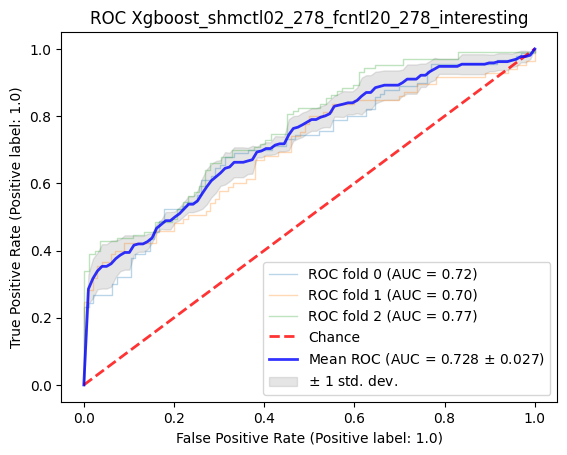

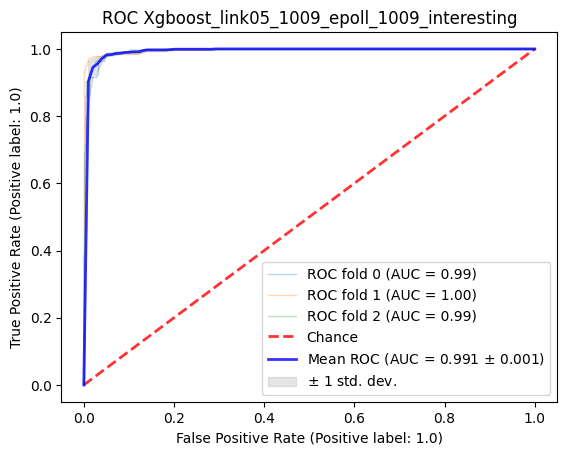

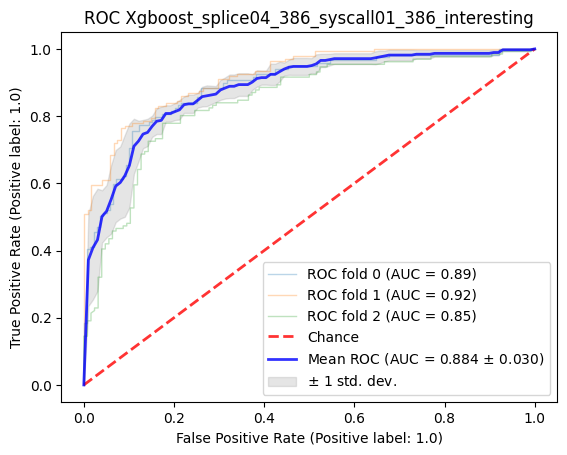

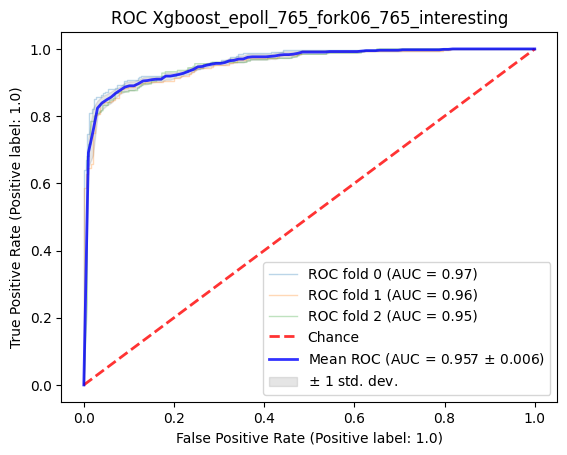

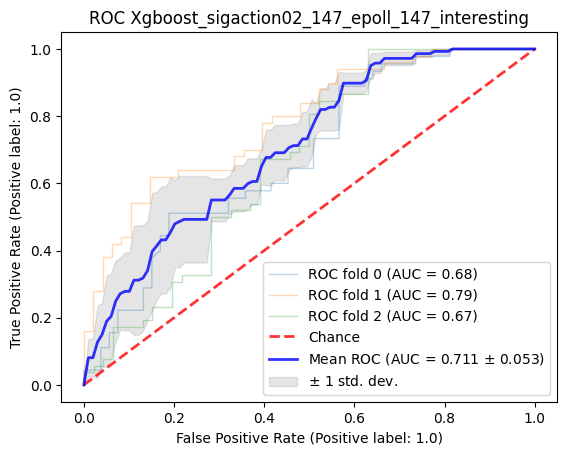

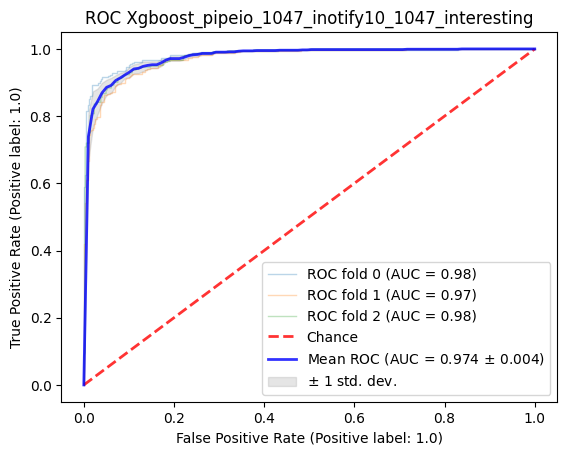

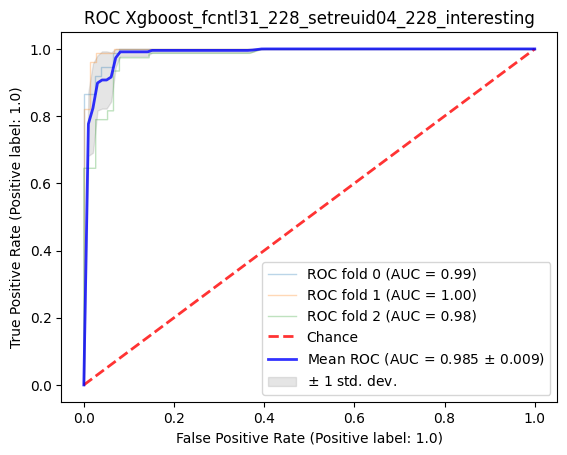

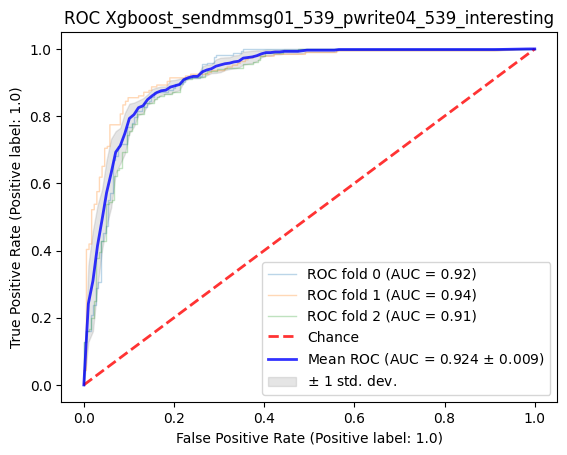

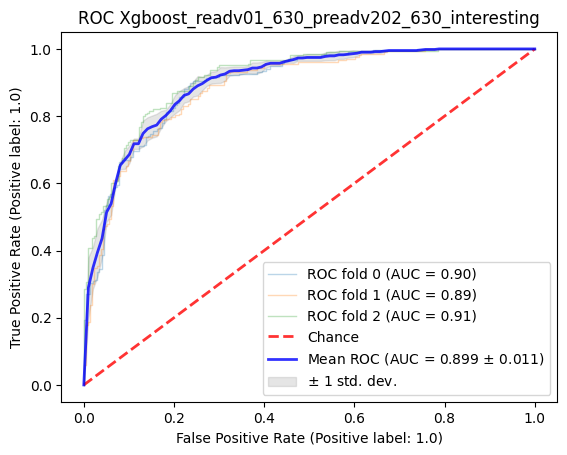

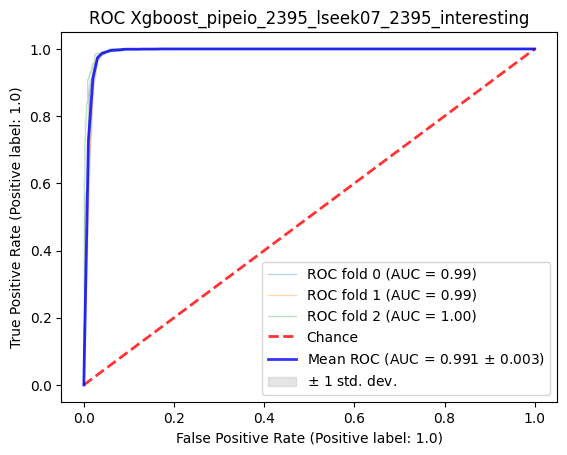

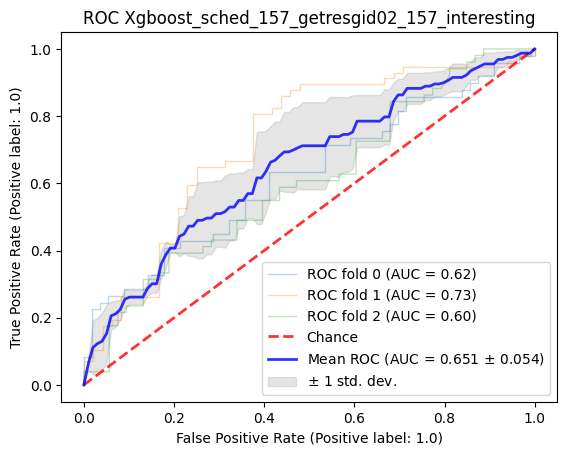

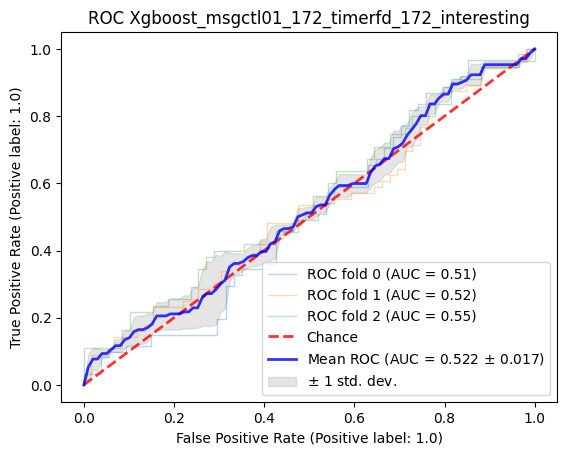

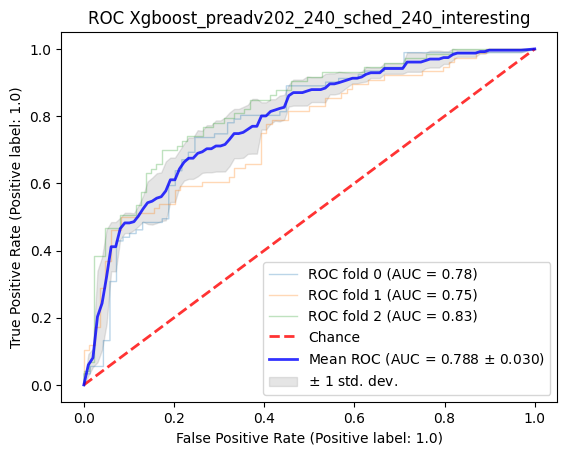

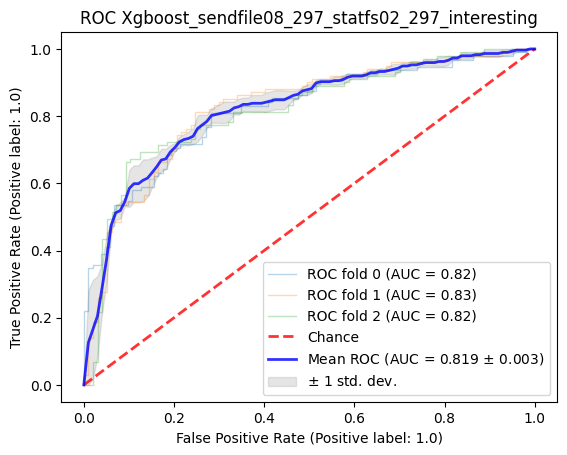

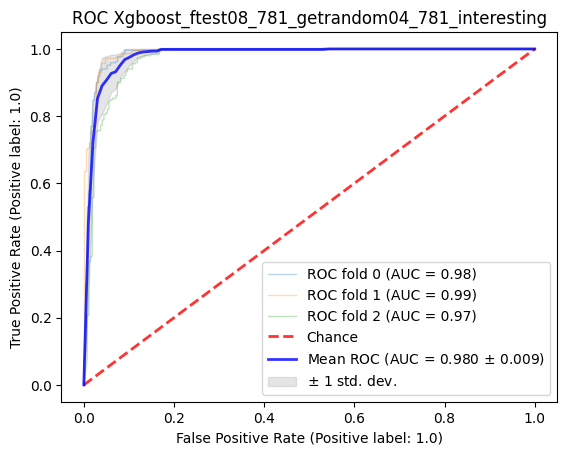

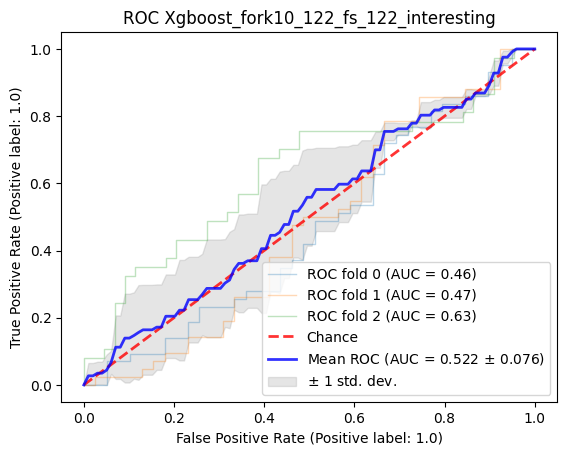

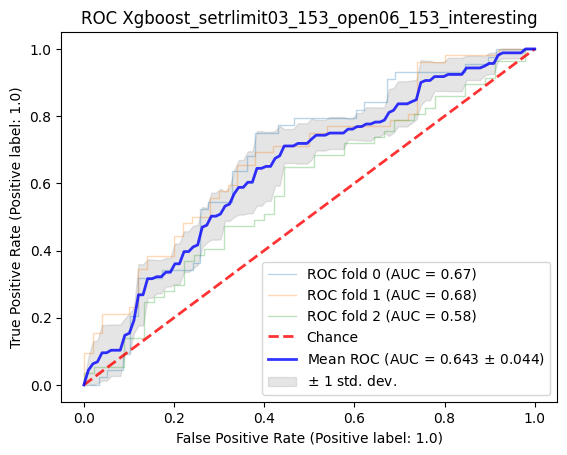

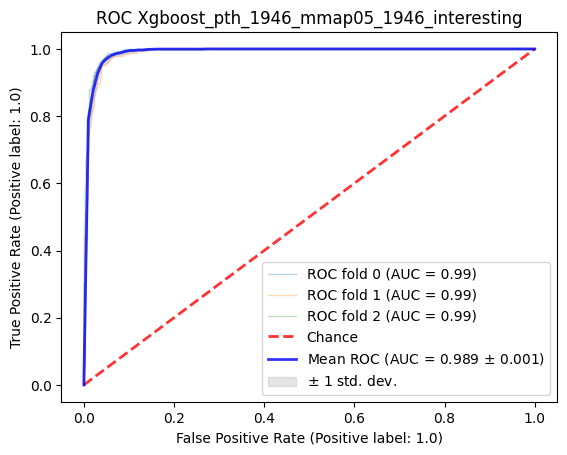

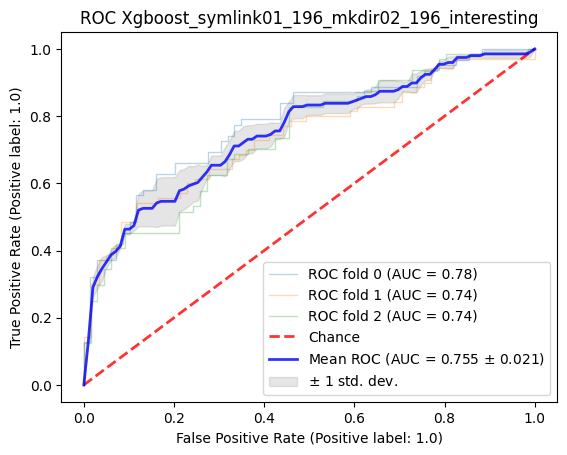

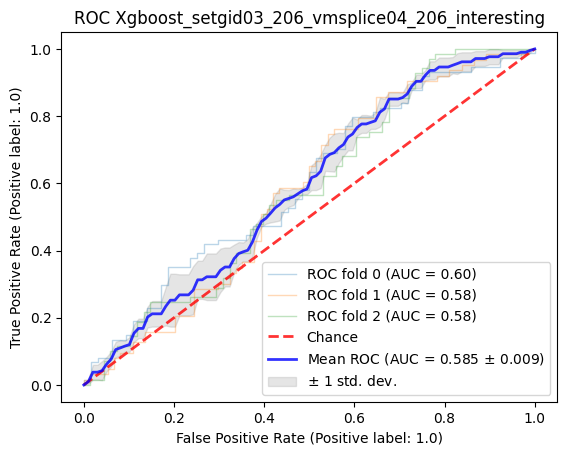

In [114]:
# ROC AUC for just insteresting windows

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn import svm
from sklearn.metrics import mean_squared_error, auc, RocCurveDisplay
cv = KFold(n_splits=3, shuffle=True)

version = 3
datafolder_path = './processed_LTP_v' + str(version) + '/' 
processed_files = glob.glob(datafolder_path+"interesting_*.npy")

# labels 1--> trace A normal, 2--> trace B normal, 3--> insteresting tarces
# for perplexity_rate in [3,10,15,20,25,30,35]:
# select_files = processed_files[:2]
# if 1:

for epoch in range(20):
    random_numbers = np.random.randint(low=0, high=len(processed_files), size=2)
    select_files = [processed_files[i] for i in random_numbers]
    # sublist = [my_list[i] for i in indices]
    all_data =[]
    all_labels =[]
    all_interesting = []
    all_interesting_label = []
    all_normal = []
    all_normal_label = []
    counter = 0
    for processed_file in select_files:
        
        file_name = os.path.basename(processed_file)
        
        # interesting_filename = 'interesting_' + file_name
        # interesting_files_path = datafolder_path + interesting_filename

        tem_data_interesting = np.load(processed_file)
        # file_name = os.path.basename(processed_file)
        print("file name is ", file_name)
        if counter ==0:
            file_name1 = file_name
        else:
            file_name2 = file_name
        # tem_data_processed = np.load(processed_file)
        
        # all_normal.append(tem_data_processed)
        # all_normal_label.append(np.ones(len(tem_data_processed))*counter)
   
        all_interesting.append(tem_data_interesting[0])
        all_interesting_label.append(np.ones(len(tem_data_interesting[0]))*counter)
        
        # all_data.append(np.concatenate((tem_data_interesting, tem_data_processed), axis=0))
        # else:
        #     all_data.append(tem_data_processed)
        counter +=1
        # print("all_data shape is", len(all_data))
        # all_labels.append(np.concatenate((np.ones(len(tem_data_interesting))*1, np.ones(len(tem_data_processed))*0),axis=0))
        
    # all_all_data = np.concatenate(all_data, axis=0)   
    # all_all_labels = np.concatenate(all_labels, axis=0)
    all_all_interesting  = np.concatenate(all_interesting, axis=0)
    all_all_interesting_label = np.concatenate(all_interesting_label, axis=0)
    # all_all_normal  = np.concatenate(all_normal, axis=0)
    # all_all_normal_label = np.concatenate(all_normal_label, axis=0)
    # assert len(all_all_labels) == len(all_all_normal_label) + len(all_all_interesting_label)
    # print(len(all_all_normal_label))
    print(len(all_all_interesting_label))
    
    # X = all_all_normal
    # clean_y = np.copy(all_all_normal_label)
    # y = clean_y


    title_all = ['interesting','normal','both']


    for exp_num in [0]: #0--> AB interesting, 1 --> AB normal, 2 --> AB all 
        if exp_num == 0:
            X_org = all_all_interesting
            clean_y = np.copy(all_all_interesting_label)
        elif exp_num == 1:
            X_org = all_all_normal
            clean_y = np.copy(all_all_normal_label)
        elif exp_num ==2:
            X_org = all_all_data
            clean_y = np.copy(all_all_labels)
        y_org = clean_y

        tprs = []
        aucs = []       

        from imblearn.over_sampling import SMOTE

        # resample all classes but the majority class
        # smote = SMOTE('minority')
        smote = SMOTE()
        X, y = smote.fit_resample(X_org, y_org)
        xg_reg = xgb.XGBClassifier(objective ='binary:logistic', subsample=0.9,
                        max_depth = 50,n_estimators = 10, use_label_encoder=False)
        # X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)
        # kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
        mean_fpr = np.linspace(0, 1, 100)
        # title = "ROC Xgboost for 2 traces (label 0: trace A "+title_all[exp_num]+" windows Num=" +str(len(clean_y[clean_y==0])) + ") \n (label 1: trace B "+title_all[exp_num]+" windows Num= "+str(len(clean_y[clean_y==1]))+")" 
        title ='ROC Xgboost_'+file_name1.split("_")[4] + '_' +str(len(y[y==0]))+'_'+ file_name2.split("_")[4]+'_'+str(len(y[y==1]))+'_'+str(title_all[exp_num])
        fig, ax = plt.subplots()
        for i, (train, test) in enumerate(cv.split(X,y)):
            xg_reg.fit(X[train], y[train])
            viz = RocCurveDisplay.from_estimator(
                xg_reg,
                X[test],
                y[test],
                name="ROC fold {}".format(i),
                alpha=0.3,
                lw=1,
                ax=ax,
            )
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title=title,
        )
        ax.legend(loc="lower right")
        # plt.show()
        # fig.savefig(save_path + 'Xgb_ROC_normal_AB_traces_v2.png')
        # if mean_auc > 0.60:
        fig.savefig(save_path + 'Xgb_ROC_'+title_all[exp_num]+'_AB_traces_'+str(epoch)+'_v'+str(version)+'_shuffle.png')
        


In [88]:
len(all_interesting)
all_interesting[0].shape
tem_data_interesting[0].shape
all_all_interesting_label
# X
len(all_interesting[1])
all_all_interesting.shape
# clean_y.shape

(320, 155)

/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


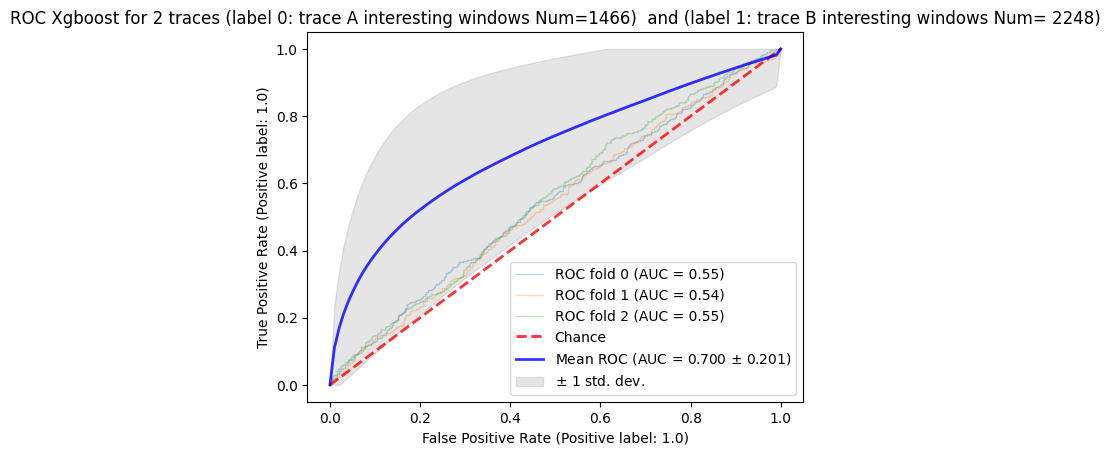

In [45]:
# str(len(clean_y[clean_y==0]))
X = all_all_interesting
clean_y = np.copy(all_all_interesting_label)
y = clean_y

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', subsample=0.9,
                max_depth = 50,n_estimators = 10, use_label_encoder=False)
# X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)
# kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
mean_fpr = np.linspace(0, 1, 100)
# title = "ROC Xgboos with "+str(len(all_data)) +" traces (label 0: trace A&B normal windows)  and (label 1: trace A&B interesting windows)"
# title = "ROC Xgboost for  "+str(len(all_data)) +" traces (label 0: trace A interesting windows Num=" +str(len(clean_y[clean_y==0])) + ")  and (label 1: interesting windows Num= "+str(len(clean_y[clean_y==1]))+")" 
title = "ROC Xgboost for 2 traces (label 0: trace A interesting windows Num=" +str(len(clean_y[clean_y==0])) + ")  and (label 1: trace B interesting windows Num= "+str(len(clean_y[clean_y==1]))+")" 

fig, ax = plt.subplots()
# all_range = list(range(len(all_both_data)))
for i, (train, test) in enumerate(cv.split(X,y)):
    xg_reg.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        xg_reg,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=title,
)
ax.legend(loc="lower right")
plt.show()

file name is  ./processed_LTP/interesting_processed_batch1_50_buffer_size_400_LTP_confstr01_06-07-2023_183954_sig.npy
both_data shape is 1
file name is  ./processed_LTP/interesting_processed_batch1_50_buffer_size_400_LTP_inotify05_06-07-2023_224945_sig.npy
both_data shape is 2


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


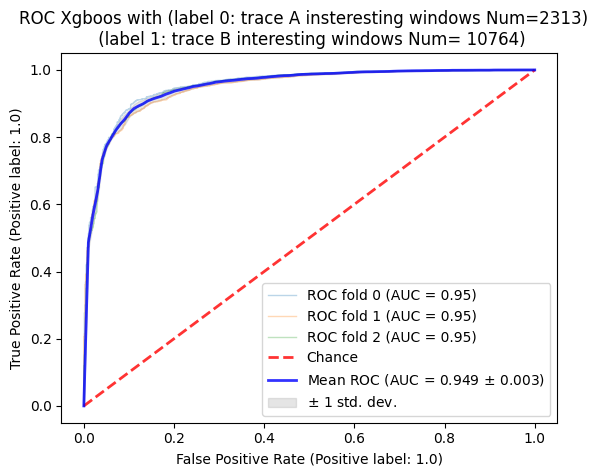

In [19]:
# ROC AUC for two insteresting windows only 

tprs = []
aucs = []


both_data =[]
both_labels =[]
counter = 0
datafolder_path = './processed_LTP/'
processed_files = glob.glob(datafolder_path+"processed_*.npy")
for processed_file in processed_files[:2]:
    counter+=1
        
    file_name = os.path.basename(processed_file)
    if counter == 1:
        file_name1 = file_name
    else:
        file_name2 = file_name
    interesting_filename = 'interesting_' + file_name
    # org_files = org_folder + file_name[10:]
    interesting_files_path = datafolder_path + interesting_filename
    # file_name = os.path.basename(org_files)
    print("file name is ", interesting_files_path)
    
    tem_data_interesting = np.load(interesting_files_path)
    # X_embedded_interesting = TSNE(n_components=2, learning_rate='auto',
    #               init='random', perplexity=3).fit_transform(tem_data_interesting)
    
    # file_name = os.path.basename(processed_file)
    # print("file name is ", file_name)
    tem_data_processed = np.load(processed_file)
    both_data.append(tem_data_interesting)
    # both_data.append(np.concatenate((tem_data_interesting, tem_data_processed), axis=0))
    print("both_data shape is", len(both_data))
    both_labels.append(np.ones(len(tem_data_interesting))* (counter-1))
    # both_labels.append(np.concatenate((np.ones(len(tem_data_interesting))*3, np.ones(len(tem_data_processed))*counter),axis=0))
    
all_both_data = np.concatenate(both_data, axis=0)   
all_both_labels = np.concatenate(both_labels, axis=0)

cv = KFold(n_splits=3, shuffle=True)
X = all_both_data
# clean_y = 
clean_y = np.copy(all_both_labels)
# clean_y[(clean_y == 1) | (clean_y == 2)] = 0
# clean_y[clean_y == 3] = 1
y = clean_y



xg_reg = xgb.XGBClassifier(objective ='binary:logistic', subsample=0.9,
                max_depth = 50,n_estimators = 10, use_label_encoder=False)
# X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)
# kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
mean_fpr = np.linspace(0, 1, 100)
title = "ROC Xgboos with (label 0: trace A insteresting windows Num=" +str(len(all_both_labels[all_both_labels==0])) + ")  \n (label 1: trace B interesting windows Num= "+str(len(all_both_labels[all_both_labels==1]))+")" 
fig, ax = plt.subplots()
all_range = list(range(len(all_both_data)))
for i, (train, test) in enumerate(cv.split(X,y)):
    xg_reg.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        xg_reg,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=title,
)
ax.legend(loc="lower right")
plt.show()

interesting_filename is  interesting_levenshtein_distance_LTP_getcwd03_06-07-2023_214340_sig.npy
file name is  common_levenshtein_distance_LTP_getcwd03_06-07-2023_214340_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_alarm06_06-07-2023_175521_sig.npy
file name is  common_levenshtein_distance_LTP_alarm06_06-07-2023_175521_sig.npy
545
285


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_tar_tests.sh_06-08-2023_173645_sig.npy
file name is  common_levenshtein_distance_LTP_tar_tests.sh_06-08-2023_173645_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_mmap19_06-08-2023_001429_sig.npy
file name is  common_levenshtein_distance_LTP_mmap19_06-08-2023_001429_sig.npy
554
395


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_exit01_06-07-2023_193715_sig.npy
file name is  common_levenshtein_distance_LTP_exit01_06-07-2023_193715_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_mmapstress02_06-08-2023_163618_sig.npy
file name is  common_levenshtein_distance_LTP_mmapstress02_06-08-2023_163618_sig.npy
363
228


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_sigaction01_06-08-2023_051318_sig.npy
file name is  common_levenshtein_distance_LTP_sigaction01_06-08-2023_051318_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_stream05_06-08-2023_080559_sig.npy
file name is  common_levenshtein_distance_LTP_stream05_06-08-2023_080559_sig.npy
463
216


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_fcntl07_06-07-2023_201506_sig.npy
file name is  common_levenshtein_distance_LTP_fcntl07_06-07-2023_201506_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_capset01_06-07-2023_180553_sig.npy
file name is  common_levenshtein_distance_LTP_capset01_06-07-2023_180553_sig.npy
709
550


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_thp04_06-08-2023_175319_sig.npy
file name is  common_levenshtein_distance_LTP_thp04_06-08-2023_175319_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_execl01_06-07-2023_192536_sig.npy
file name is  common_levenshtein_distance_LTP_execl01_06-07-2023_192536_sig.npy
8702
2572


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_fcntl17_06-07-2023_203031_sig.npy
file name is  common_levenshtein_distance_LTP_fcntl17_06-07-2023_203031_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_inotify11_06-07-2023_225440_sig.npy
file name is  common_levenshtein_distance_LTP_inotify11_06-07-2023_225440_sig.npy
881
641


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_chmod07_06-07-2023_181510_sig.npy
file name is  common_levenshtein_distance_LTP_chmod07_06-07-2023_181510_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_getitimer02_06-07-2023_220035_sig.npy
file name is  common_levenshtein_distance_LTP_getitimer02_06-07-2023_220035_sig.npy
739
312


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_du01.sh_06-08-2023_174101_sig.npy
file name is  common_levenshtein_distance_LTP_du01.sh_06-08-2023_174101_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_ftest03_06-08-2023_080910_sig.npy
file name is  common_levenshtein_distance_LTP_ftest03_06-08-2023_080910_sig.npy
1201
710


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_timerfd01_06-08-2023_061712_sig.npy
file name is  common_levenshtein_distance_LTP_timerfd01_06-08-2023_061712_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_truncate02_64_06-08-2023_063253_sig.npy
file name is  common_levenshtein_distance_LTP_truncate02_64_06-08-2023_063253_sig.npy
528
459


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_ftest07_06-08-2023_081454_sig.npy
file name is  common_levenshtein_distance_LTP_ftest07_06-08-2023_081454_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_mincore02_06-08-2023_011825_sig.npy
file name is  common_levenshtein_distance_LTP_mincore02_06-08-2023_011825_sig.npy
1049
415


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/var/folders/pg/21p768nj7ql8xc_qftsb78n00000gn/T/ipykernel_39654/3548960996.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_writev05_06-08-2023_073259_sig.npy
file name is  common_levenshtein_distance_LTP_writev05_06-08-2023_073259_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_renameat202_06-09-2023_152106_sig.npy
file name is  common_levenshtein_distance_LTP_renameat202_06-09-2023_152106_sig.npy
246
130


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_newuname01_06-08-2023_012322_sig.npy
file name is  common_levenshtein_distance_LTP_newuname01_06-08-2023_012322_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_fs_perms_06-08-2023_084530_sig.npy
file name is  common_levenshtein_distance_LTP_fs_perms_06-08-2023_084530_sig.npy
380
217


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_capget02_06-07-2023_180530_sig.npy
file name is  common_levenshtein_distance_LTP_capget02_06-07-2023_180530_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_readv01_06-08-2023_023638_sig.npy
file name is  common_levenshtein_distance_LTP_readv01_06-08-2023_023638_sig.npy
1892
1099


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_setegid01_06-08-2023_041310_sig.npy
file name is  common_levenshtein_distance_LTP_setegid01_06-08-2023_041310_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_setresuid05_06-08-2023_043431_sig.npy
file name is  common_levenshtein_distance_LTP_setresuid05_06-08-2023_043431_sig.npy
714
456


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_setuid04_06-08-2023_045033_sig.npy
file name is  common_levenshtein_distance_LTP_setuid04_06-08-2023_045033_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_getrlimit02_06-07-2023_222806_sig.npy
file name is  common_levenshtein_distance_LTP_getrlimit02_06-07-2023_222806_sig.npy
635
374


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_alarm03_06-07-2023_174942_sig.npy
file name is  common_levenshtein_distance_LTP_alarm03_06-07-2023_174942_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_chroot02_06-07-2023_182259_sig.npy
file name is  common_levenshtein_distance_LTP_chroot02_06-07-2023_182259_sig.npy
576
284


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_getpagesize01_06-07-2023_220109_sig.npy
file name is  common_levenshtein_distance_LTP_getpagesize01_06-07-2023_220109_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_mkdir04_06-07-2023_234632_sig.npy
file name is  common_levenshtein_distance_LTP_mkdir04_06-07-2023_234632_sig.npy
544
266


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_open09_06-08-2023_011545_sig.npy
file name is  common_levenshtein_distance_LTP_open09_06-08-2023_011545_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_nice02_06-08-2023_010207_sig.npy
file name is  common_levenshtein_distance_LTP_nice02_06-08-2023_010207_sig.npy
478
247


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


interesting_filename is  interesting_levenshtein_distance_LTP_getpriority02_06-07-2023_221013_sig.npy
file name is  common_levenshtein_distance_LTP_getpriority02_06-07-2023_221013_sig.npy
interesting_filename is  interesting_levenshtein_distance_LTP_setegid02_06-08-2023_041317_sig.npy
file name is  common_levenshtein_distance_LTP_setegid02_06-08-2023_041317_sig.npy
651
376


/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/xinzha02/miniconda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


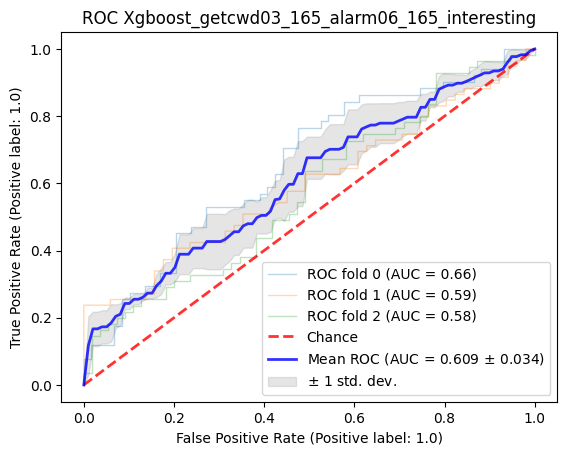

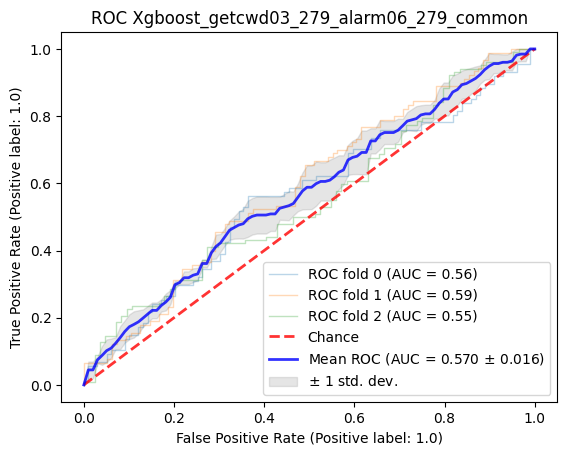

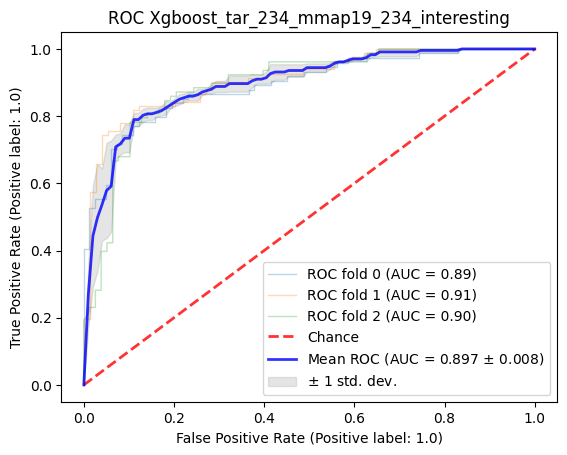

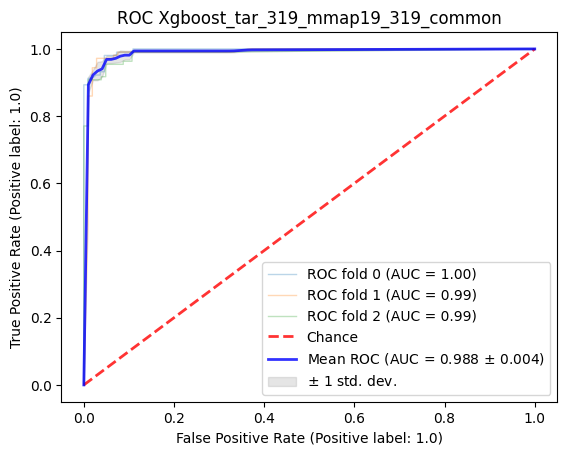

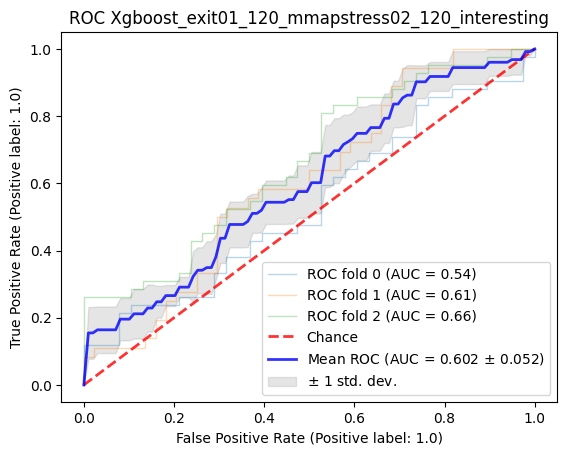

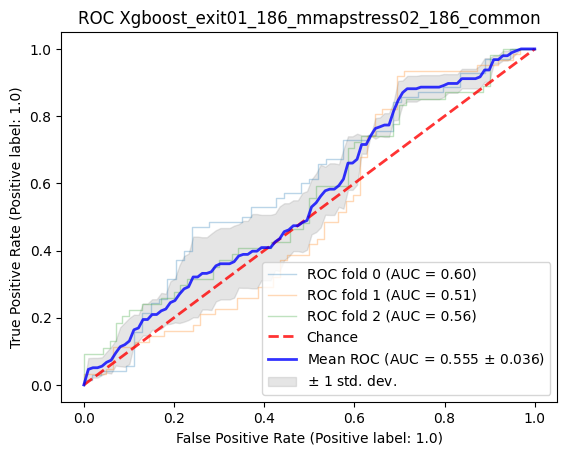

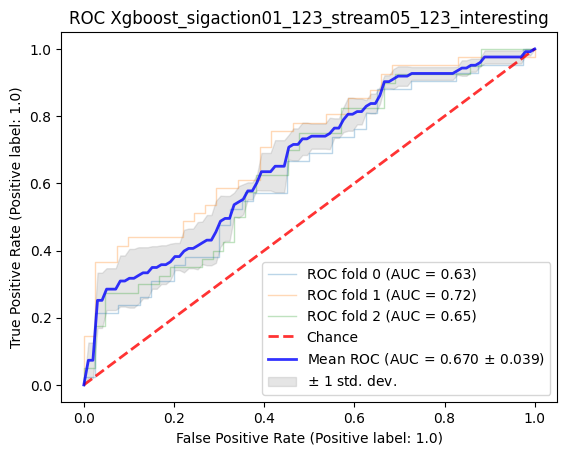

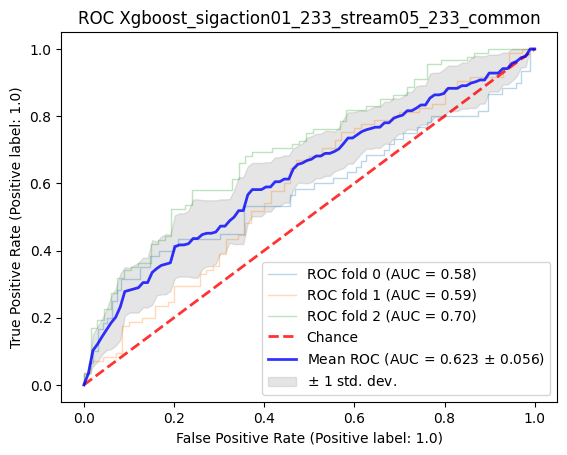

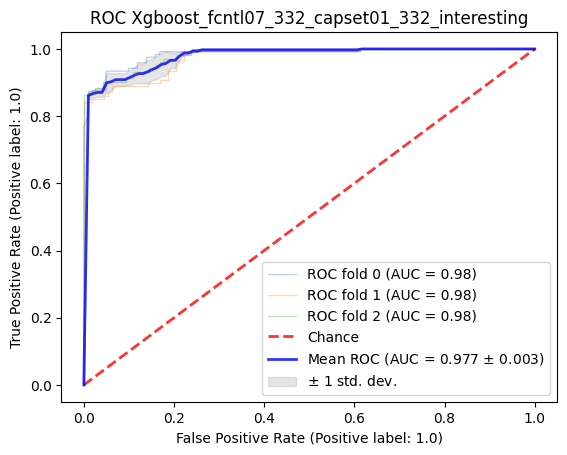

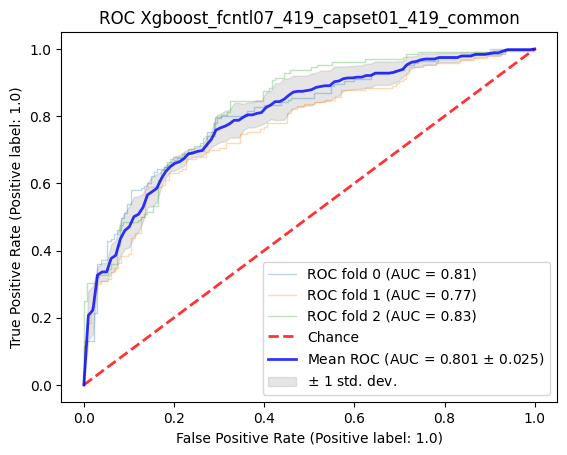

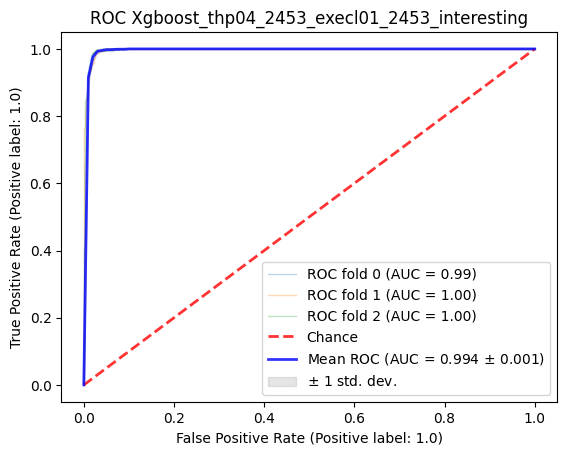

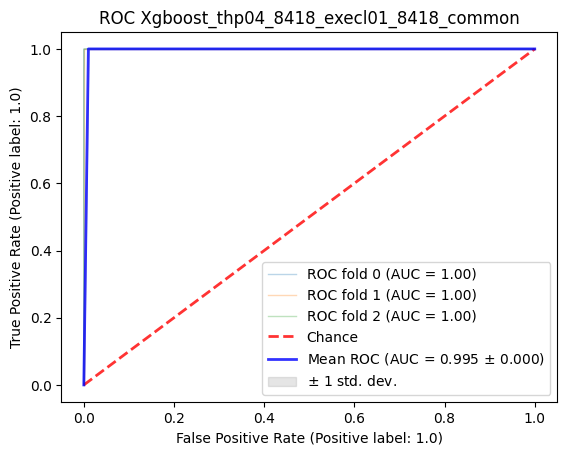

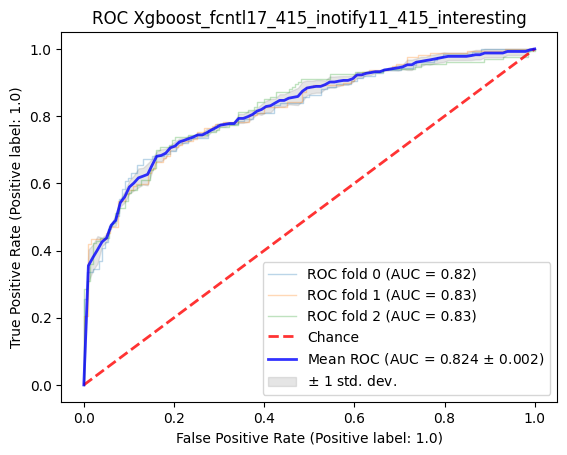

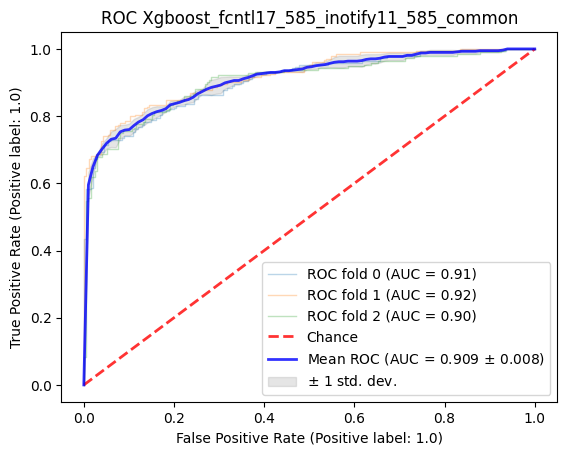

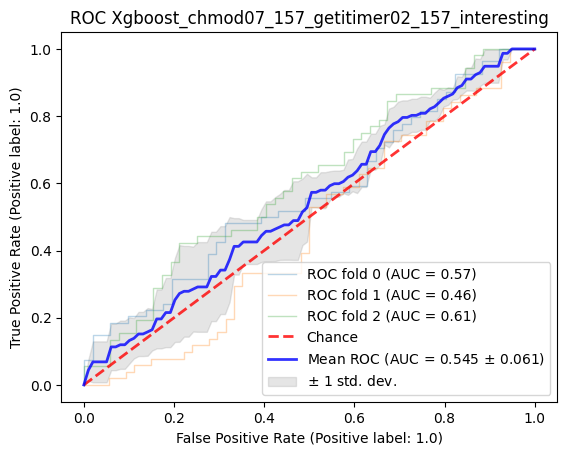

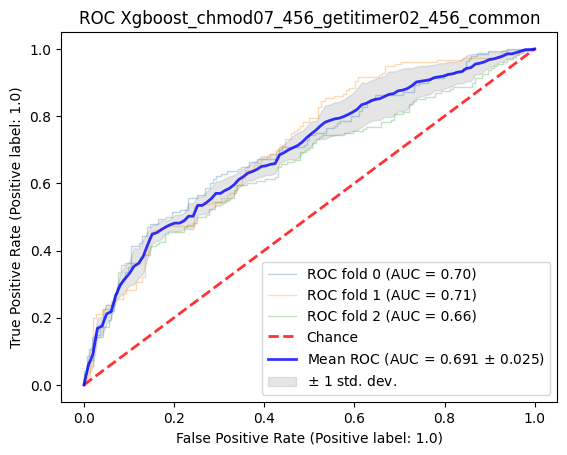

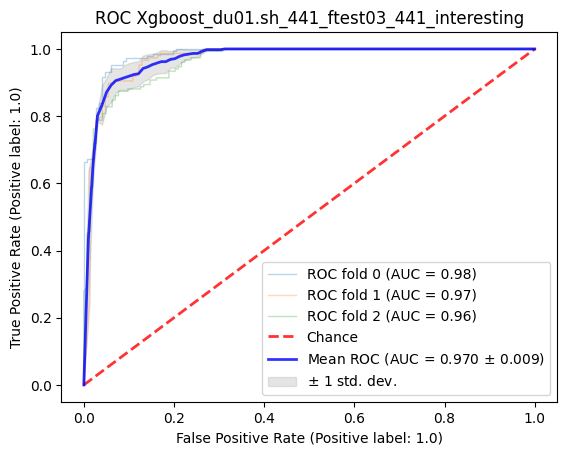

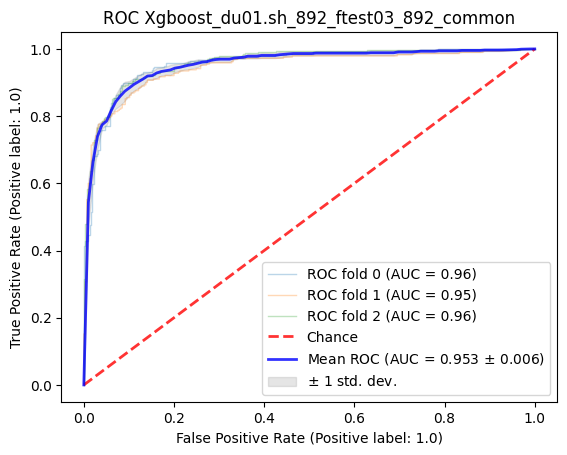

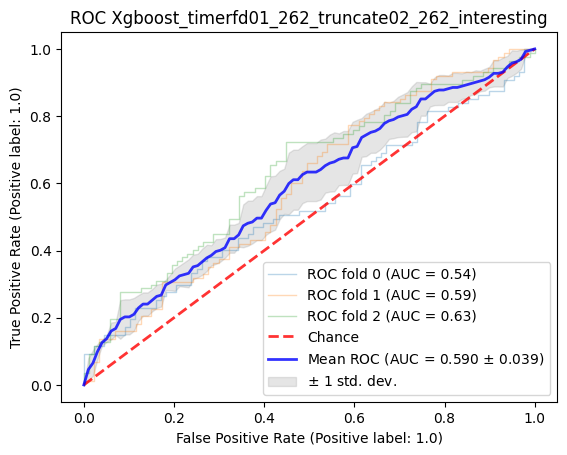

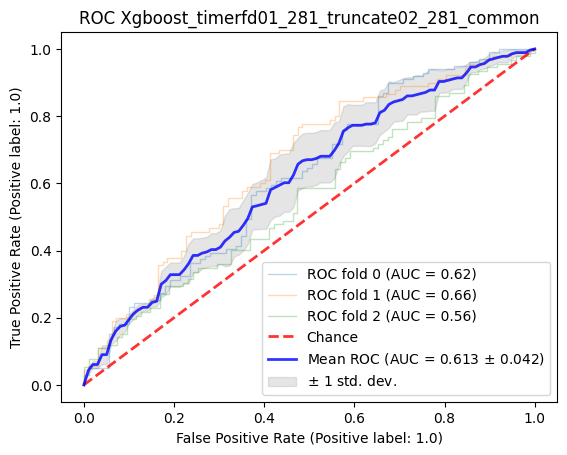

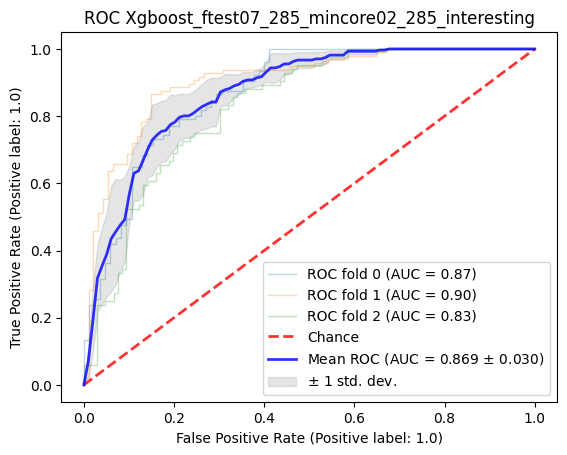

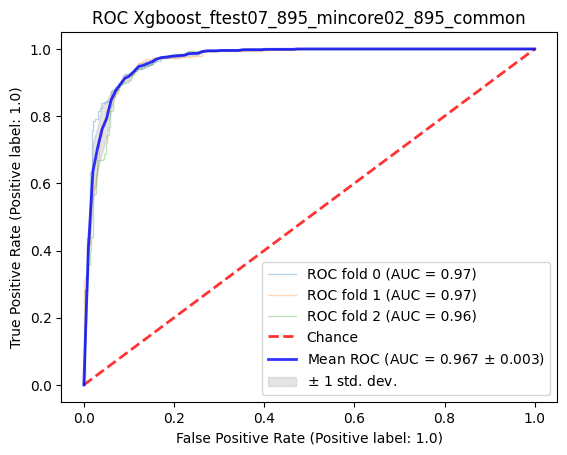

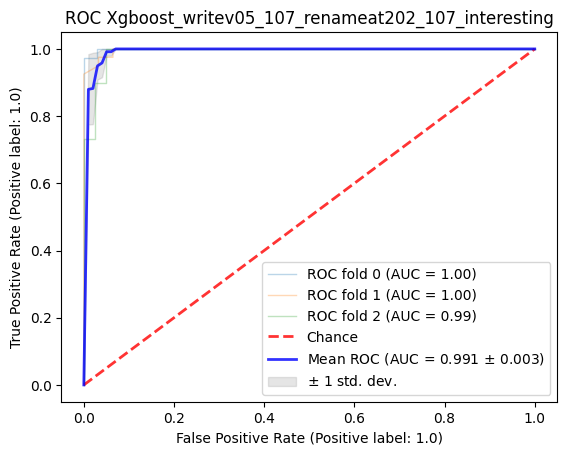

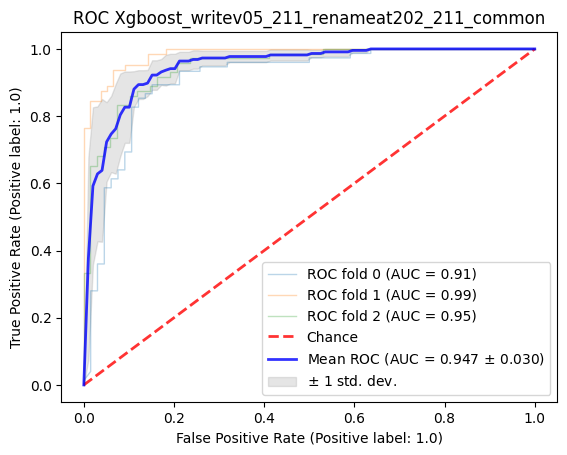

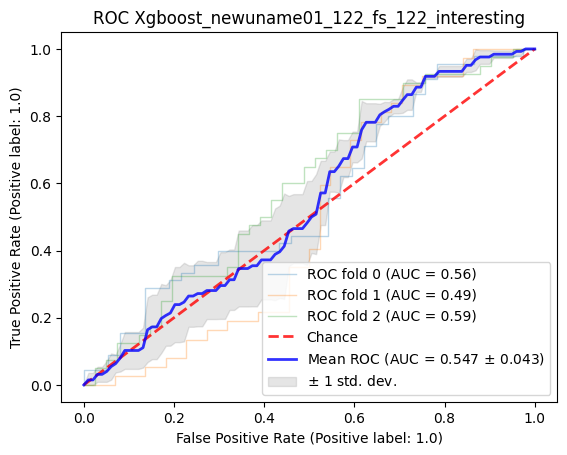

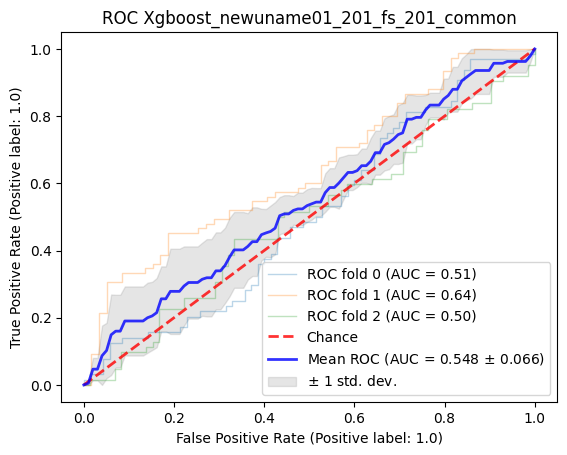

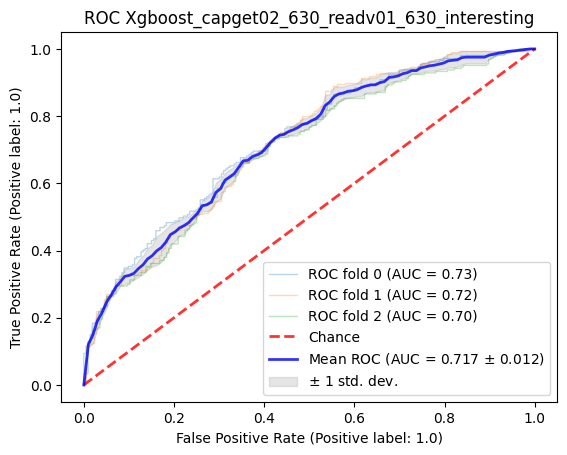

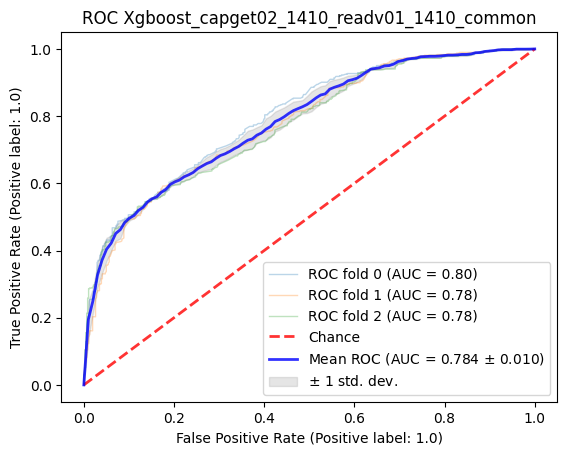

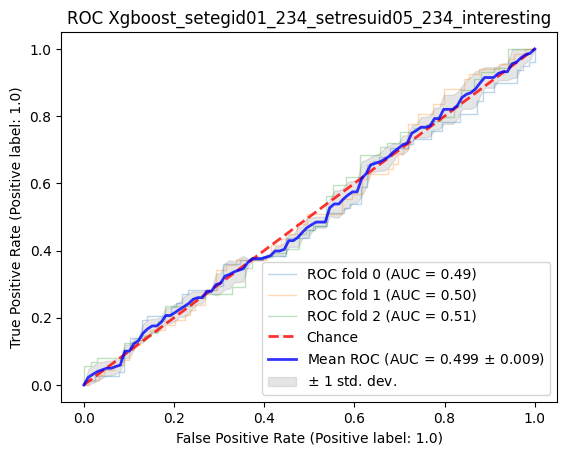

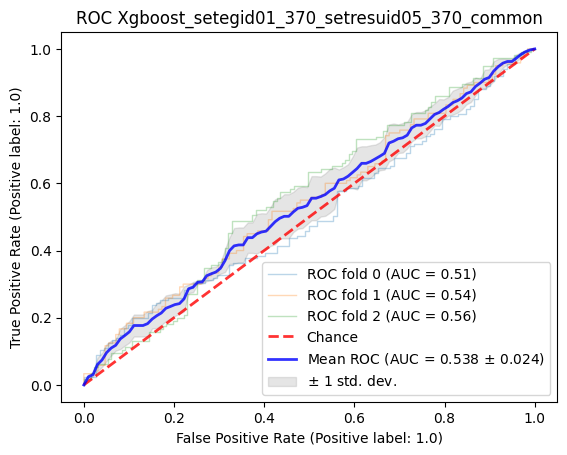

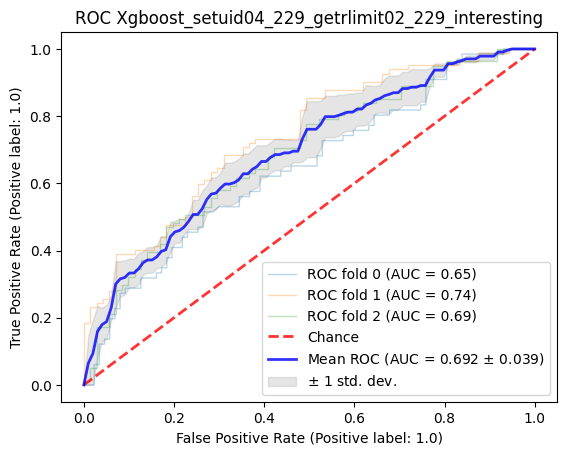

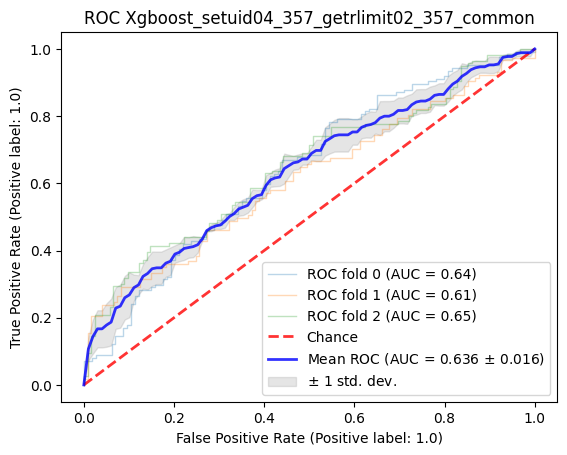

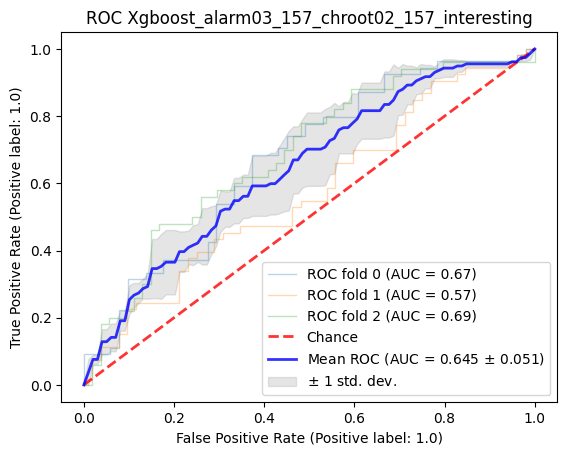

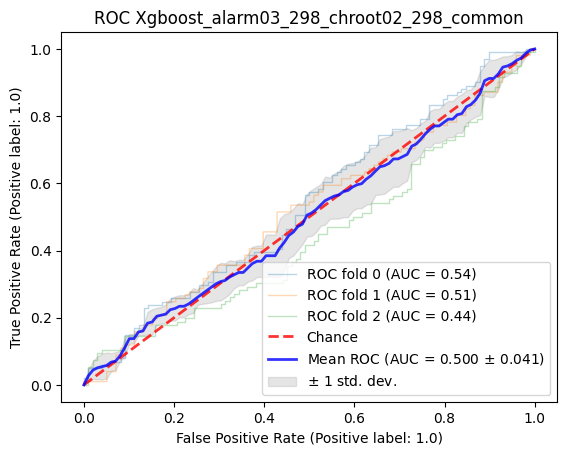

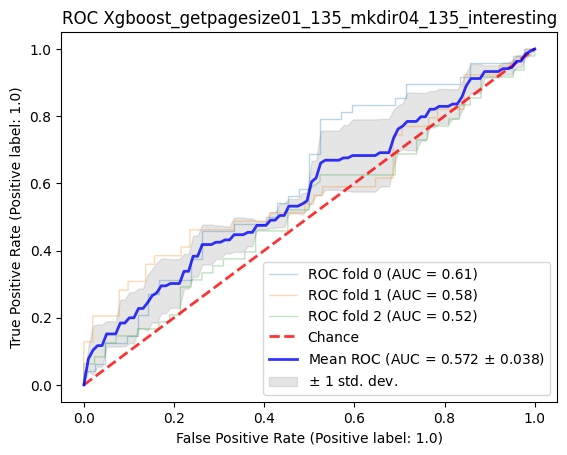

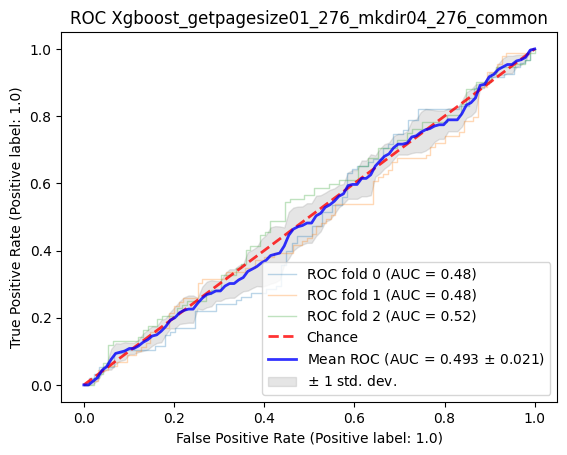

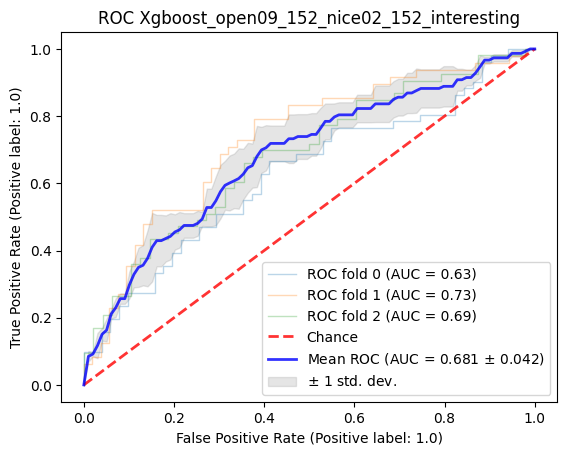

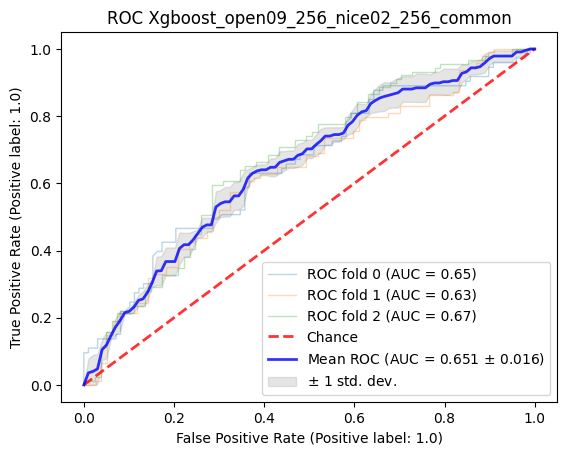

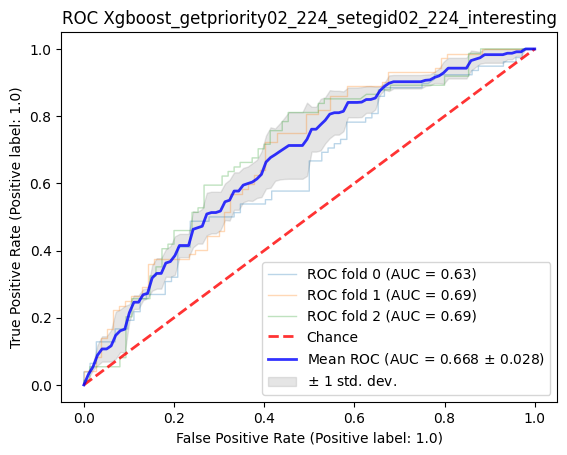

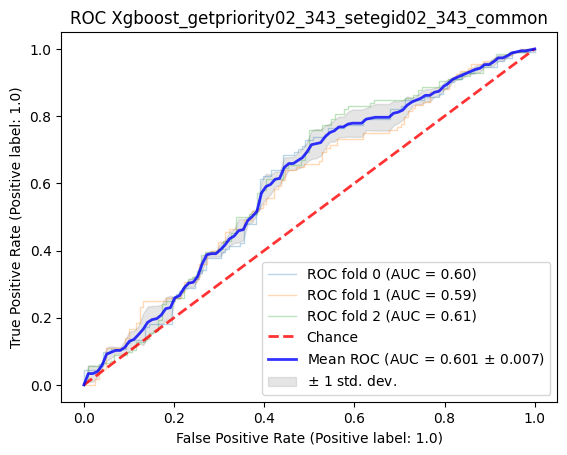

In [118]:
# ROC AUC for v3 common and interesting

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn import svm
from sklearn.metrics import mean_squared_error, auc, RocCurveDisplay
from imblearn.over_sampling import SMOTE
cv = KFold(n_splits=3, shuffle=True)

version = 3
datafolder_path = './processed_LTP_v' + str(version) + '/' 
processed_files = glob.glob(datafolder_path+"common_*.npy")

# labels 1--> trace A normal, 2--> trace B normal, 3--> insteresting tarces
for epoch in range(20):
    random_numbers = np.random.randint(low=0, high=len(processed_files), size=2)
    select_files = [processed_files[i] for i in random_numbers]
    # sublist = [my_list[i] for i in indices]
    all_data =[]
    all_labels =[]
    all_interesting = []
    all_interesting_label = []
    all_normal = []
    all_normal_label = []
    counter = 0
    for processed_file in select_files:
        file_name = os.path.basename(processed_file)
        interesting_filename = 'interesting_' + file_name[7:]
        print("interesting_filename is ", interesting_filename)
        interesting_files_path = datafolder_path + interesting_filename

        tem_data_interesting = np.load(interesting_files_path)[0]
        file_name = os.path.basename(processed_file)
        print("file name is ", file_name)

        if counter ==0:
            file_name1 = file_name
        else:
            file_name2 = file_name
        tem_data_processed = np.load(processed_file)[0]
        
        all_normal.append(tem_data_processed)
        all_normal_label.append(np.ones(len(tem_data_processed))*counter)
   
        all_interesting.append(tem_data_interesting)
        all_interesting_label.append(np.ones(len(tem_data_interesting))*counter)

        counter +=1
    # all_all_data = np.concatenate(all_data, axis=0)   
    # all_all_labels = np.concatenate(all_labels, axis=0)
    all_all_interesting  = np.concatenate(all_interesting, axis=0)
    all_all_interesting_label = np.concatenate(all_interesting_label, axis=0)
    all_all_normal  = np.concatenate(all_normal, axis=0)
    all_all_normal_label = np.concatenate(all_normal_label, axis=0)
    # assert len(all_all_labels) == len(all_all_normal_label) + len(all_all_interesting_label)
    print(len(all_all_normal_label))
    print(len(all_all_interesting_label))


    title_all = ['interesting','common','both']

    for exp_num in [0,1]: #0--> AB interesting, 1 --> AB normal, 2 --> AB all 
        if exp_num == 0:
            X_org = all_all_interesting
            y_org = np.copy(all_all_interesting_label)
        elif exp_num == 1:
            X_org = all_all_normal
            y_org = np.copy(all_all_normal_label)
        elif exp_num ==2:
            X_org = all_all_data
            y_org = np.copy(all_all_labels)

        tprs = []
        aucs = []
        # resample all classes but the majority class
        smote = SMOTE()
        X, y = smote.fit_resample(X_org, y_org)

        xg_reg = xgb.XGBClassifier(objective ='binary:logistic', subsample=0.9,
                        max_depth = 50,n_estimators = 10, use_label_encoder=False)
        # X_embedded_all = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(all_both_data)
        # kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
        mean_fpr = np.linspace(0, 1, 100)
        title ='ROC Xgboost_'+file_name1.split("_")[4] + '_' +str(len(y[y==0]))+'_'+ file_name2.split("_")[4]+'_'+str(len(y[y==1]))+'_'+str(title_all[exp_num])
        fig, ax = plt.subplots()
        for i, (train, test) in enumerate(cv.split(X,y)):
            xg_reg.fit(X[train], y[train])
            viz = RocCurveDisplay.from_estimator(
                xg_reg,
                X[test],
                y[test],
                name="ROC fold {}".format(i),
                alpha=0.3,
                lw=1,
                ax=ax,
            )
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title=title,
        )
        ax.legend(loc="lower right")
        save_path = 'tsne_akira/v3/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        
        fig.savefig(save_path + 'Xgb_ROC_'+title_all[exp_num]+'_AB_traces_v3_mean_auc_'+str(mean_auc)+'_'+str(epoch)+'_.png')
        
